**After running the Gradient Boost models with RandomizedSearchCV optimization, our model had a ROCAUC score of .871 and accuracy of 85% for predicting H1N1 vaccinations and a ROCAUC score of .860 and accuracy score of 79% for seasonal vaccination predictions.**

## Imports

We begin by importing the necessary tools to do our modeling and perform the evaluation metrics. For competition purposes we also load the submission dataset from DrivenData to perform our model on.

In [9]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import numpy as np
%matplotlib inline

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

In [12]:
from category_encoders import OrdinalEncoder as oe
from catboost import CatBoostClassifier

In [13]:
from catboost import CatBoostClassifier
from catboost import Pool, cv
import optuna
import pandas_profiling as pp

## Load Data

We load our datasets and separate the columns in order for CatBoost to use in its algorithm. We can pass numeric and ordinal columns but need to specifically tell CatBoost what columns are categorical so that it can use its own one encoding in the algorithm.

In [14]:
train = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')

In [15]:
labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

In [16]:
test = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

In [17]:
num_cols = train.select_dtypes('number').columns

In [18]:
cat_cols = ['race', 'sex', 'marital_status', 'rent_or_own',  'hhs_geo_region','census_msa', 'employment_industry', 'employment_occupation']

In [19]:
ord_cols = ['age_group', 'education',  'income_poverty','employment_status']

## Imputation

We also impute the columns to fill all the null/nan values and use LabelEncoder to assign a numerical value to the ordinal columns so that its values are not passed as strings.

In [20]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [21]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [22]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [23]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

In [26]:
le = LabelEncoder()
for col in ord_cols:
    train[col] = le.fit_transform(train[col])

In [27]:
for col in ord_cols:
    pd.to_numeric(train[col])

## Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.3, random_state=10)

## CatBoost using pool, cross validation + Optuna

Here is where we tell CatBoost which columns will be categorical.

In [29]:
categorical_features_indices = np.where(X_train.dtypes == object)[0]
categorical_features_indices

array([23, 24, 26, 27, 29, 30, 33, 34], dtype=int64)

CatBoost will deal with all the columns that are useless while Optuna helps to optimize the hyperparameters to find the model that best predicts our targets.

## Optuna - H1N1 Vaccine

In [30]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [31]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength':trial.suggest_int('random_strength', 1,10),
        'bagging_temperature':trial.suggest_int('bagging_temperature', 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        'depth': trial.suggest_int('max_depth', 2,10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        'loss_function': "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [33]:
sampler = optuna.samplers.TPESampler(seed=68)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-01-27 19:12:47,019] A new study created in memory with name: no-name-67febd3e-0410-4c3e-91a4-c957cdf72b85
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/5]

bestTest = 0.4378797821
bestIteration = 521

Training on fold [1/5]

bestTest = 0.4288854702
bestIteration = 581

Training on fold [2/5]

bestTest = 0.4194612655
bestIteration = 608

Training on fold [3/5]

bestTest = 0.4145951194
bestIteration = 516

Training on fold [4/5]


[I 2022-01-27 19:13:00,742] Trial 0 finished with value: 0.8653884155925278 and parameters: {'iterations': 1500, 'learning_rate': 0.029356482739949695, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4264221821
bestIteration = 511

Training on fold [0/5]

bestTest = 0.4338590892
bestIteration = 138

Training on fold [1/5]

bestTest = 0.432445671
bestIteration = 112

Training on fold [2/5]

bestTest = 0.419293143
bestIteration = 122

Training on fold [3/5]

bestTest = 0.415217499
bestIteration = 126

Training on fold [4/5]


[I 2022-01-27 19:13:04,402] Trial 1 finished with value: 0.8650085807981238 and parameters: {'iterations': 200, 'learning_rate': 0.1464067066361795, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4240930487
bestIteration = 130

Training on fold [0/5]

bestTest = 0.4364301523
bestIteration = 65

Training on fold [1/5]

bestTest = 0.4422756567
bestIteration = 35

Training on fold [2/5]

bestTest = 0.4221845911
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4133322629
bestIteration = 74

Training on fold [4/5]


[I 2022-01-27 19:13:19,525] Trial 2 finished with value: 0.862198216830157 and parameters: {'iterations': 200, 'learning_rate': 0.27287829596201946, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.427717353
bestIteration = 55

Training on fold [0/5]

bestTest = 0.4375926253
bestIteration = 346

Training on fold [1/5]

bestTest = 0.4335444038
bestIteration = 430

Training on fold [2/5]

bestTest = 0.419502049
bestIteration = 433

Training on fold [3/5]

bestTest = 0.4147262716
bestIteration = 451

Training on fold [4/5]


[I 2022-01-27 19:13:56,111] Trial 3 finished with value: 0.8646185028404252 and parameters: {'iterations': 1200, 'learning_rate': 0.0603209284932487, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4287301706
bestIteration = 424

Training on fold [0/5]

bestTest = 0.437820801
bestIteration = 63

Training on fold [1/5]

bestTest = 0.434737339
bestIteration = 74

Training on fold [2/5]

bestTest = 0.421200785
bestIteration = 87

Training on fold [3/5]

bestTest = 0.4159954047
bestIteration = 58

Training on fold [4/5]


[I 2022-01-27 19:13:58,586] Trial 4 finished with value: 0.8623243905590329 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4294427339
bestIteration = 77

Training on fold [0/5]

bestTest = 0.4983793991
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4909418196
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4800092991
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4752109038
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 19:14:01,111] Trial 5 finished with value: 0.8533211249498922 and parameters: {'iterations': 100, 'learning_rate': 0.06628011038512191, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4864926814
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4357219875
bestIteration = 108

Training on fold [1/5]

bestTest = 0.4415180086
bestIteration = 101

Training on fold [2/5]

bestTest = 0.4196994919
bestIteration = 110

Training on fold [3/5]

bestTest = 0.4128075404
bestIteration = 121

Training on fold [4/5]


[I 2022-01-27 19:14:48,370] Trial 6 finished with value: 0.8637858641634992 and parameters: {'iterations': 1200, 'learning_rate': 0.09658215406978513, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4296283871
bestIteration = 85

Training on fold [0/5]

bestTest = 0.4679412674
bestIteration = 84

Training on fold [1/5]

bestTest = 0.4666173241
bestIteration = 104

Training on fold [2/5]

bestTest = 0.454456757
bestIteration = 92

Training on fold [3/5]

bestTest = 0.4474043441
bestIteration = 88

Training on fold [4/5]


[I 2022-01-27 19:14:50,816] Trial 7 finished with value: 0.8644891851818329 and parameters: {'iterations': 500, 'learning_rate': 0.2714096381817127, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4596372149
bestIteration = 72

Training on fold [0/5]

bestTest = 0.4349873236
bestIteration = 80

Training on fold [1/5]

bestTest = 0.437334784
bestIteration = 86

Training on fold [2/5]

bestTest = 0.4190739375
bestIteration = 85

Training on fold [3/5]

bestTest = 0.4226906197
bestIteration = 76

Training on fold [4/5]


[I 2022-01-27 19:14:53,302] Trial 8 finished with value: 0.8628997857330354 and parameters: {'iterations': 1500, 'learning_rate': 0.2053434310118264, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.424033751
bestIteration = 82

Training on fold [0/5]

bestTest = 0.4550788956
bestIteration = 37

Training on fold [1/5]

bestTest = 0.4496170498
bestIteration = 18

Training on fold [2/5]

bestTest = 0.4347903394
bestIteration = 36

Training on fold [3/5]

bestTest = 0.4351549973
bestIteration = 38

Training on fold [4/5]


[I 2022-01-27 19:15:40,974] Trial 9 finished with value: 0.8539903652941861 and parameters: {'iterations': 100, 'learning_rate': 0.25900665720714294, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4386127061
bestIteration = 49

Training on fold [0/5]

bestTest = 0.4876225792
bestIteration = 901

Training on fold [1/5]

bestTest = 0.4848174843
bestIteration = 858

Training on fold [2/5]

bestTest = 0.4699271255
bestIteration = 1133

Training on fold [3/5]

bestTest = 0.4598784334
bestIteration = 1326

Training on fold [4/5]


[I 2022-01-27 19:16:20,570] Trial 10 finished with value: 0.8576559311919532 and parameters: {'iterations': 1500, 'learning_rate': 0.006050647464439618, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.007150186521078341, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4706329758
bestIteration = 1205

Training on fold [0/5]

bestTest = 0.4383300458
bestIteration = 103

Training on fold [1/5]

bestTest = 0.4369191724
bestIteration = 109

Training on fold [2/5]

bestTest = 0.4228269417
bestIteration = 106

Training on fold [3/5]

bestTest = 0.4155276123
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 19:16:25,611] Trial 11 finished with value: 0.8629048757418974 and parameters: {'iterations': 200, 'learning_rate': 0.13750920329129512, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.06857418244454487, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4244022484
bestIteration = 115

Training on fold [0/5]

bestTest = 0.4415504209
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4343989914
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4282470767
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4189992738
bestIteration = 85

Training on fold [4/5]


[I 2022-01-27 19:16:28,959] Trial 12 finished with value: 0.8611710716314096 and parameters: {'iterations': 1000, 'learning_rate': 0.16136188689816064, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.00013028549097931553, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4254590076
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4470310345
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4431802931
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4326422706
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4274032569
bestIteration = 199

Training on fold [4/5]


[I 2022-01-27 19:16:35,981] Trial 13 finished with value: 0.8609248893693385 and parameters: {'iterations': 200, 'learning_rate': 0.015312092326589866, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 0.21656942139045643, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4368823075
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4884660755
bestIteration = 53

Training on fold [1/5]

bestTest = 0.4742487883
bestIteration = 100

Training on fold [2/5]

bestTest = 0.4633045577
bestIteration = 97

Training on fold [3/5]

bestTest = 0.454609055
bestIteration = 101

Training on fold [4/5]


[I 2022-01-27 19:18:21,480] Trial 14 finished with value: 0.8561913333037037 and parameters: {'iterations': 1500, 'learning_rate': 0.14690216116501453, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 0.0012700604558864655, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4820063357
bestIteration = 55

Training on fold [0/5]

bestTest = 0.4358033342
bestIteration = 157

Training on fold [1/5]

bestTest = 0.4359794715
bestIteration = 116

Training on fold [2/5]

bestTest = 0.4176518035
bestIteration = 168

Training on fold [3/5]

bestTest = 0.4161760442
bestIteration = 140

Training on fold [4/5]


[I 2022-01-27 19:18:44,237] Trial 15 finished with value: 0.864199125773494 and parameters: {'iterations': 500, 'learning_rate': 0.10902072034609422, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 9.46314667205651e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4261777295
bestIteration = 135

Training on fold [0/5]

bestTest = 0.4350358433
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4312022669
bestIteration = 88

Training on fold [2/5]

bestTest = 0.4218789099
bestIteration = 101

Training on fold [3/5]

bestTest = 0.4147449176
bestIteration = 87

Training on fold [4/5]


[I 2022-01-27 19:18:47,038] Trial 16 finished with value: 0.865269548409708 and parameters: {'iterations': 300, 'learning_rate': 0.18724782574165397, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 0.002044181008008903, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4230671341
bestIteration = 117

Training on fold [0/5]

bestTest = 0.4524108208
bestIteration = 55

Training on fold [1/5]

bestTest = 0.4561335201
bestIteration = 20

Training on fold [2/5]

bestTest = 0.435028635
bestIteration = 45

Training on fold [3/5]

bestTest = 0.4330767215
bestIteration = 33

Training on fold [4/5]


[I 2022-01-27 19:18:49,108] Trial 17 finished with value: 0.8529254965662292 and parameters: {'iterations': 300, 'learning_rate': 0.1959685464095528, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 0.0008448032982377925, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.4342052296
bestIteration = 61

Training on fold [0/5]

bestTest = 0.4772950444
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4730891591
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4631928674
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4545620789
bestIteration = 299

Training on fold [4/5]


[I 2022-01-27 19:18:55,415] Trial 18 finished with value: 0.8616251644554694 and parameters: {'iterations': 300, 'learning_rate': 0.03916309270975399, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 2.750136202078559e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8653884155925278.



bestTest = 0.46900707
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4325038377
bestIteration = 90

Training on fold [1/5]

bestTest = 0.4268445619
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4182186309
bestIteration = 72

Training on fold [3/5]

bestTest = 0.408190191
bestIteration = 146

Training on fold [4/5]


[I 2022-01-27 19:18:58,736] Trial 19 finished with value: 0.8676485381457519 and parameters: {'iterations': 1000, 'learning_rate': 0.23628610596512684, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 5, 'l2_leaf_reg': 99.11695455168547, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4224681779
bestIteration = 75

Training on fold [0/5]

bestTest = 0.4366558313
bestIteration = 65

Training on fold [1/5]

bestTest = 0.4270237501
bestIteration = 110

Training on fold [2/5]

bestTest = 0.4176958053
bestIteration = 74

Training on fold [3/5]

bestTest = 0.4064420855
bestIteration = 102

Training on fold [4/5]


[I 2022-01-27 19:19:02,552] Trial 20 finished with value: 0.8674753613907743 and parameters: {'iterations': 1000, 'learning_rate': 0.2435939992133711, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 83.5361102732189, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4209722927
bestIteration = 75

Training on fold [0/5]

bestTest = 0.4393008451
bestIteration = 52

Training on fold [1/5]

bestTest = 0.4318039501
bestIteration = 54

Training on fold [2/5]

bestTest = 0.417736719
bestIteration = 72

Training on fold [3/5]

bestTest = 0.4089798832
bestIteration = 63

Training on fold [4/5]


[I 2022-01-27 19:19:05,734] Trial 21 finished with value: 0.8656499193900947 and parameters: {'iterations': 1000, 'learning_rate': 0.29869995206003336, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 97.19978662487846, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4219686795
bestIteration = 56

Training on fold [0/5]

bestTest = 0.4337093957
bestIteration = 60

Training on fold [1/5]

bestTest = 0.4286696099
bestIteration = 75

Training on fold [2/5]

bestTest = 0.4195775798
bestIteration = 66

Training on fold [3/5]

bestTest = 0.407007959
bestIteration = 76

Training on fold [4/5]


[I 2022-01-27 19:19:09,317] Trial 22 finished with value: 0.866225212300775 and parameters: {'iterations': 1000, 'learning_rate': 0.2958581323596662, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 91.69888044928044, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4256582632
bestIteration = 53

Training on fold [0/5]

bestTest = 0.4351452883
bestIteration = 60

Training on fold [1/5]

bestTest = 0.4320769445
bestIteration = 67

Training on fold [2/5]

bestTest = 0.4171887954
bestIteration = 65

Training on fold [3/5]

bestTest = 0.4112805283
bestIteration = 75

Training on fold [4/5]


[I 2022-01-27 19:19:12,907] Trial 23 finished with value: 0.8661462202105854 and parameters: {'iterations': 1000, 'learning_rate': 0.23906515316928975, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 89.94436397893094, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4243055497
bestIteration = 65

Training on fold [0/5]

bestTest = 0.456266327
bestIteration = 25

Training on fold [1/5]

bestTest = 0.4452790354
bestIteration = 24

Training on fold [2/5]

bestTest = 0.4338050956
bestIteration = 29

Training on fold [3/5]

bestTest = 0.4268388809
bestIteration = 19

Training on fold [4/5]


[I 2022-01-27 19:19:14,752] Trial 24 finished with value: 0.8549473281674013 and parameters: {'iterations': 1000, 'learning_rate': 0.29755956091120445, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 0.8819361741496387, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4340604357
bestIteration = 30

Training on fold [0/5]

bestTest = 0.4385899416
bestIteration = 67

Training on fold [1/5]

bestTest = 0.4309556356
bestIteration = 54

Training on fold [2/5]

bestTest = 0.4223220527
bestIteration = 69

Training on fold [3/5]

bestTest = 0.4117100718
bestIteration = 65

Training on fold [4/5]


[I 2022-01-27 19:19:18,051] Trial 25 finished with value: 0.8650398606933507 and parameters: {'iterations': 1000, 'learning_rate': 0.24213450684227086, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 24.255990500428627, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4224813645
bestIteration = 89

Training on fold [0/5]

bestTest = 0.4748881574
bestIteration = 67

Training on fold [1/5]

bestTest = 0.4727415118
bestIteration = 61

Training on fold [2/5]

bestTest = 0.4602691936
bestIteration = 63

Training on fold [3/5]

bestTest = 0.4452167247
bestIteration = 60

Training on fold [4/5]


[I 2022-01-27 19:19:21,995] Trial 26 finished with value: 0.8617192329858037 and parameters: {'iterations': 1000, 'learning_rate': 0.21852411773622293, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 1.4671077365106504, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 19 with value: 0.8676485381457519.



bestTest = 0.4623285217
bestIteration = 71

Training on fold [0/5]

bestTest = 0.4296391673
bestIteration = 122

Training on fold [1/5]

bestTest = 0.426995926
bestIteration = 126

Training on fold [2/5]

bestTest = 0.4164085992
bestIteration = 122

Training on fold [3/5]

bestTest = 0.4110515239
bestIteration = 112

Training on fold [4/5]


[I 2022-01-27 19:19:26,053] Trial 27 finished with value: 0.8681162261007787 and parameters: {'iterations': 1000, 'learning_rate': 0.1737998679520284, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 14.937013918277646, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 27 with value: 0.8681162261007787.



bestTest = 0.4198161651
bestIteration = 112

Training on fold [0/5]

bestTest = 0.4369225465
bestIteration = 90

Training on fold [1/5]

bestTest = 0.4306158311
bestIteration = 84

Training on fold [2/5]

bestTest = 0.4197102848
bestIteration = 89

Training on fold [3/5]

bestTest = 0.4116605294
bestIteration = 120

Training on fold [4/5]


[I 2022-01-27 19:19:52,191] Trial 28 finished with value: 0.8654716070662619 and parameters: {'iterations': 1000, 'learning_rate': 0.17117934956091047, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.47230055820807965, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 27 with value: 0.8681162261007787.



bestTest = 0.4246121964
bestIteration = 121

Training on fold [0/5]

bestTest = 0.431706835
bestIteration = 101

Training on fold [1/5]

bestTest = 0.4307246603
bestIteration = 90

Training on fold [2/5]

bestTest = 0.4192683091
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4093364254
bestIteration = 104

Training on fold [4/5]


[I 2022-01-27 19:19:55,907] Trial 29 finished with value: 0.8669992850574981 and parameters: {'iterations': 1000, 'learning_rate': 0.18174251196312802, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 13.877706996845497, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 27 with value: 0.8681162261007787.



bestTest = 0.4209943082
bestIteration = 92

Training on fold [0/5]

bestTest = 0.4309149912
bestIteration = 132

Training on fold [1/5]

bestTest = 0.4306756893
bestIteration = 137

Training on fold [2/5]

bestTest = 0.4173692176
bestIteration = 116

Training on fold [3/5]

bestTest = 0.4077032762
bestIteration = 173

Training on fold [4/5]


[I 2022-01-27 19:20:29,394] Trial 30 finished with value: 0.8673266749022652 and parameters: {'iterations': 1000, 'learning_rate': 0.12590269344110375, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 6.365704619771397, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 27 with value: 0.8681162261007787.



bestTest = 0.4238678217
bestIteration = 165

Training on fold [0/5]

bestTest = 0.4305493922
bestIteration = 158

Training on fold [1/5]

bestTest = 0.4281566404
bestIteration = 159

Training on fold [2/5]

bestTest = 0.4159716411
bestIteration = 149

Training on fold [3/5]

bestTest = 0.4095311785
bestIteration = 167

Training on fold [4/5]


[I 2022-01-27 19:21:07,054] Trial 31 finished with value: 0.868180468534953 and parameters: {'iterations': 1000, 'learning_rate': 0.12019366281355286, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 9.653249931764423, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.868180468534953.



bestTest = 0.4213476624
bestIteration = 163

Training on fold [0/5]

bestTest = 0.4302823284
bestIteration = 163

Training on fold [1/5]

bestTest = 0.4298338211
bestIteration = 173

Training on fold [2/5]

bestTest = 0.4141175176
bestIteration = 182

Training on fold [3/5]

bestTest = 0.4066015493
bestIteration = 184

Training on fold [4/5]


[I 2022-01-27 19:21:49,777] Trial 32 finished with value: 0.8682739718021623 and parameters: {'iterations': 1000, 'learning_rate': 0.10702346620442124, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 31.19222108555743, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8682739718021623.



bestTest = 0.4240746973
bestIteration = 163

Training on fold [0/5]

bestTest = 0.4325608447
bestIteration = 138

Training on fold [1/5]

bestTest = 0.4296192258
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4186734026
bestIteration = 156

Training on fold [3/5]

bestTest = 0.4108282635
bestIteration = 184

Training on fold [4/5]


[I 2022-01-27 19:22:29,798] Trial 33 finished with value: 0.8669912088087302 and parameters: {'iterations': 1000, 'learning_rate': 0.09178047206326728, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 0.2682105598875779, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 32 with value: 0.8682739718021623.



bestTest = 0.4240143319
bestIteration = 203

Training on fold [0/5]

bestTest = 0.4339742912
bestIteration = 127

Training on fold [1/5]

bestTest = 0.4272305728
bestIteration = 156

Training on fold [2/5]

bestTest = 0.4152230408
bestIteration = 143

Training on fold [3/5]

bestTest = 0.4050283383
bestIteration = 162

Training on fold [4/5]


[I 2022-01-27 19:23:04,467] Trial 34 finished with value: 0.8686940979392226 and parameters: {'iterations': 1200, 'learning_rate': 0.13147355170135422, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 15.867600430679772, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4208324495
bestIteration = 148

Training on fold [0/5]

bestTest = 0.433748889
bestIteration = 124

Training on fold [1/5]

bestTest = 0.4362105721
bestIteration = 95

Training on fold [2/5]

bestTest = 0.418460716
bestIteration = 158

Training on fold [3/5]

bestTest = 0.4116960696
bestIteration = 146

Training on fold [4/5]


[I 2022-01-27 19:23:35,867] Trial 35 finished with value: 0.8645472392630816 and parameters: {'iterations': 1200, 'learning_rate': 0.12180802834888922, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 0.05978948558138099, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4278324174
bestIteration = 133

Training on fold [0/5]

bestTest = 0.4323611665
bestIteration = 327

Training on fold [1/5]

bestTest = 0.4305303266
bestIteration = 237

Training on fold [2/5]

bestTest = 0.4167006597
bestIteration = 339

Training on fold [3/5]

bestTest = 0.4070251517
bestIteration = 406

Training on fold [4/5]


[I 2022-01-27 19:24:22,890] Trial 36 finished with value: 0.8672751667763594 and parameters: {'iterations': 1200, 'learning_rate': 0.07453067717867735, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 21.69540230491801, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4247297915
bestIteration = 243

Training on fold [0/5]

bestTest = 0.4348208684
bestIteration = 95

Training on fold [1/5]

bestTest = 0.4370813765
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4175389784
bestIteration = 100

Training on fold [3/5]

bestTest = 0.4134993528
bestIteration = 93

Training on fold [4/5]


[I 2022-01-27 19:25:53,622] Trial 37 finished with value: 0.8654135467168868 and parameters: {'iterations': 1200, 'learning_rate': 0.15668341078194314, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 3.420489471134607, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4207781853
bestIteration = 98

Training on fold [0/5]

bestTest = 0.4787944029
bestIteration = 99

Training on fold [1/5]

bestTest = 0.474659247
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4634864725
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4561754015
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 19:26:15,890] Trial 38 finished with value: 0.861368154179084 and parameters: {'iterations': 100, 'learning_rate': 0.08443834179104198, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 5, 'l2_leaf_reg': 7.883997428285061, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4705370998
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4311917367
bestIteration = 419

Training on fold [1/5]

bestTest = 0.4304723183
bestIteration = 369

Training on fold [2/5]

bestTest = 0.4164119871
bestIteration = 477

Training on fold [3/5]

bestTest = 0.4081524517
bestIteration = 507

Training on fold [4/5]


[I 2022-01-27 19:27:20,676] Trial 39 finished with value: 0.8677677944167168 and parameters: {'iterations': 1200, 'learning_rate': 0.0458275143662965, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 1.3837678208991369, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4230642108
bestIteration = 406

Training on fold [0/5]

bestTest = 0.4304483567
bestIteration = 177

Training on fold [1/5]

bestTest = 0.4288934356
bestIteration = 133

Training on fold [2/5]

bestTest = 0.4139381895
bestIteration = 194

Training on fold [3/5]

bestTest = 0.4097142403
bestIteration = 145

Training on fold [4/5]


[I 2022-01-27 19:28:00,041] Trial 40 finished with value: 0.8682578782714453 and parameters: {'iterations': 500, 'learning_rate': 0.10927737781184435, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 25.720868090282213, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 34 with value: 0.8686940979392226.



bestTest = 0.4213435379
bestIteration = 182

Training on fold [0/5]

bestTest = 0.4289211965
bestIteration = 192

Training on fold [1/5]

bestTest = 0.4292123428
bestIteration = 162

Training on fold [2/5]

bestTest = 0.4146791823
bestIteration = 202

Training on fold [3/5]

bestTest = 0.4069203603
bestIteration = 170

Training on fold [4/5]


[I 2022-01-27 19:28:40,301] Trial 41 finished with value: 0.8690126825753317 and parameters: {'iterations': 500, 'learning_rate': 0.1113002724930198, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 22.471853775093976, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4197784797
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4332268455
bestIteration = 136

Training on fold [1/5]

bestTest = 0.4313130237
bestIteration = 156

Training on fold [2/5]

bestTest = 0.4154798098
bestIteration = 126

Training on fold [3/5]

bestTest = 0.4063992504
bestIteration = 171

Training on fold [4/5]


[I 2022-01-27 19:29:17,449] Trial 42 finished with value: 0.8677758114955318 and parameters: {'iterations': 500, 'learning_rate': 0.12605358438028944, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 27.581209086933477, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4209323146
bestIteration = 140

Training on fold [0/5]

bestTest = 0.4315934383
bestIteration = 220

Training on fold [1/5]

bestTest = 0.4288558791
bestIteration = 172

Training on fold [2/5]

bestTest = 0.4164214051
bestIteration = 194

Training on fold [3/5]

bestTest = 0.4078164613
bestIteration = 251

Training on fold [4/5]


[I 2022-01-27 19:29:48,080] Trial 43 finished with value: 0.8677274338054595 and parameters: {'iterations': 500, 'learning_rate': 0.10984641252238424, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 3.1942530143377925, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.423831737
bestIteration = 191

Training on fold [0/5]

bestTest = 0.4345086764
bestIteration = 121

Training on fold [1/5]

bestTest = 0.430150955
bestIteration = 124

Training on fold [2/5]

bestTest = 0.4194832367
bestIteration = 130

Training on fold [3/5]

bestTest = 0.4114094301
bestIteration = 146

Training on fold [4/5]


[I 2022-01-27 19:30:18,399] Trial 44 finished with value: 0.8664187555914807 and parameters: {'iterations': 500, 'learning_rate': 0.10640209507327089, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 0.11281293871409254, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4236964107
bestIteration = 148

Training on fold [0/5]

bestTest = 0.443843082
bestIteration = 191

Training on fold [1/5]

bestTest = 0.4380675736
bestIteration = 187

Training on fold [2/5]

bestTest = 0.4220389748
bestIteration = 238

Training on fold [3/5]

bestTest = 0.4323395273
bestIteration = 115

Training on fold [4/5]


[I 2022-01-27 19:32:52,478] Trial 45 finished with value: 0.8582516301043427 and parameters: {'iterations': 500, 'learning_rate': 0.06523954107784927, 'random_strength': 10, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 2.198287698694986e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4408840264
bestIteration = 145

Training on fold [0/5]

bestTest = 0.4420785517
bestIteration = 63

Training on fold [1/5]

bestTest = 0.437658429
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4250226152
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4128634829
bestIteration = 86

Training on fold [4/5]


[I 2022-01-27 19:32:57,773] Trial 46 finished with value: 0.8627450603109665 and parameters: {'iterations': 500, 'learning_rate': 0.13700604331990246, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.8258291699430406, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4239449973
bestIteration = 91

Training on fold [0/5]

bestTest = 0.4678756484
bestIteration = 125

Training on fold [1/5]

bestTest = 0.4650899005
bestIteration = 132

Training on fold [2/5]

bestTest = 0.449907551
bestIteration = 149

Training on fold [3/5]

bestTest = 0.441018838
bestIteration = 137

Training on fold [4/5]


[I 2022-01-27 19:33:18,992] Trial 47 finished with value: 0.8665172275386788 and parameters: {'iterations': 500, 'learning_rate': 0.09825996652769572, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 0.01728548833060488, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4570655254
bestIteration = 146

Training on fold [0/5]

bestTest = 0.435889623
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4330843016
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4221073899
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4166685918
bestIteration = 199

Training on fold [4/5]


[I 2022-01-27 19:33:41,878] Trial 48 finished with value: 0.8650493534226182 and parameters: {'iterations': 200, 'learning_rate': 0.07966494599434301, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 28.893074843317223, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4284439254
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4319994122
bestIteration = 100

Training on fold [1/5]

bestTest = 0.4284066371
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4192544855
bestIteration = 84

Training on fold [3/5]

bestTest = 0.4111637286
bestIteration = 103

Training on fold [4/5]


[I 2022-01-27 19:33:59,824] Trial 49 finished with value: 0.86735620160833 and parameters: {'iterations': 1500, 'learning_rate': 0.1385252359937676, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 5.286196375330937, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4212857455
bestIteration = 94

Training on fold [0/5]

bestTest = 0.4375276156
bestIteration = 99

Training on fold [1/5]

bestTest = 0.432748984
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4200081769
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4143795042
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 19:34:24,759] Trial 50 finished with value: 0.865558030571712 and parameters: {'iterations': 100, 'learning_rate': 0.12123463671078391, 'random_strength': 10, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 40.27570536525174, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4276346436
bestIteration = 99

Training on fold [0/5]

bestTest = 0.435476414
bestIteration = 82

Training on fold [1/5]

bestTest = 0.4298492996
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4159299729
bestIteration = 123

Training on fold [3/5]

bestTest = 0.4069799042
bestIteration = 157

Training on fold [4/5]


[I 2022-01-27 19:34:50,591] Trial 51 finished with value: 0.8668229645759375 and parameters: {'iterations': 1200, 'learning_rate': 0.16687763350195214, 'random_strength': 9, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 5, 'l2_leaf_reg': 10.619646383591242, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4239646731
bestIteration = 96

Training on fold [0/5]

bestTest = 0.4377535416
bestIteration = 103

Training on fold [1/5]

bestTest = 0.4271313776
bestIteration = 121

Training on fold [2/5]

bestTest = 0.4198865621
bestIteration = 109

Training on fold [3/5]

bestTest = 0.4114989253
bestIteration = 131

Training on fold [4/5]


[I 2022-01-27 19:34:54,481] Trial 52 finished with value: 0.8660016279984262 and parameters: {'iterations': 500, 'learning_rate': 0.1455993622812518, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 5, 'l2_leaf_reg': 2.2166439519301524, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4228877624
bestIteration = 126

Training on fold [0/5]

bestTest = 0.4316746933
bestIteration = 142

Training on fold [1/5]

bestTest = 0.4282254371
bestIteration = 133

Training on fold [2/5]

bestTest = 0.415698902
bestIteration = 143

Training on fold [3/5]

bestTest = 0.4069831728
bestIteration = 194

Training on fold [4/5]


[I 2022-01-27 19:35:39,280] Trial 53 finished with value: 0.8681743189515501 and parameters: {'iterations': 200, 'learning_rate': 0.1145360149746225, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 6, 'l2_leaf_reg': 12.73983831991451, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4212429252
bestIteration = 170

Training on fold [0/5]

bestTest = 0.4331116906
bestIteration = 140

Training on fold [1/5]

bestTest = 0.430636998
bestIteration = 159

Training on fold [2/5]

bestTest = 0.4133413558
bestIteration = 165

Training on fold [3/5]

bestTest = 0.407862787
bestIteration = 144

Training on fold [4/5]


[I 2022-01-27 19:36:22,234] Trial 54 finished with value: 0.8681639533566564 and parameters: {'iterations': 200, 'learning_rate': 0.11065173855802717, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 8.051138032803168, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4200679066
bestIteration = 141

Training on fold [0/5]

bestTest = 0.4335152861
bestIteration = 128

Training on fold [1/5]

bestTest = 0.430899726
bestIteration = 130

Training on fold [2/5]

bestTest = 0.4126662206
bestIteration = 175

Training on fold [3/5]

bestTest = 0.4099487777
bestIteration = 153

Training on fold [4/5]


[I 2022-01-27 19:37:03,622] Trial 55 finished with value: 0.8676017785609128 and parameters: {'iterations': 200, 'learning_rate': 0.13070131692724174, 'random_strength': 7, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 39.80170192738923, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.421784077
bestIteration = 134

Training on fold [0/5]

bestTest = 0.4753488934
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4730600787
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4585018514
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4532775852
bestIteration = 199

Training on fold [4/5]


[I 2022-01-27 19:38:11,166] Trial 56 finished with value: 0.8625601452994424 and parameters: {'iterations': 200, 'learning_rate': 0.05229959146984369, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 4, 'l2_leaf_reg': 0.3111997436403436, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4676293022
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4347638242
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4316736039
bestIteration = 143

Training on fold [2/5]

bestTest = 0.4163088656
bestIteration = 163

Training on fold [3/5]

bestTest = 0.4091736377
bestIteration = 184

Training on fold [4/5]


[I 2022-01-27 19:39:01,679] Trial 57 finished with value: 0.8666967650200593 and parameters: {'iterations': 300, 'learning_rate': 0.09521234818016476, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 7, 'l2_leaf_reg': 3.016409819607613, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4228582716
bestIteration = 152

Training on fold [0/5]

bestTest = 0.4365466597
bestIteration = 93

Training on fold [1/5]

bestTest = 0.4341009546
bestIteration = 95

Training on fold [2/5]

bestTest = 0.418092873
bestIteration = 132

Training on fold [3/5]

bestTest = 0.4132567645
bestIteration = 106

Training on fold [4/5]


[I 2022-01-27 19:39:18,537] Trial 58 finished with value: 0.8646799796959599 and parameters: {'iterations': 1500, 'learning_rate': 0.1496329311314266, 'random_strength': 8, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 7, 'max_depth': 4, 'l2_leaf_reg': 0.0002415199858903817, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4248603788
bestIteration = 118

Training on fold [0/5]

bestTest = 0.4399770137
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4337533548
bestIteration = 71

Training on fold [2/5]

bestTest = 0.420008432
bestIteration = 100

Training on fold [3/5]

bestTest = 0.4113594929
bestIteration = 120

Training on fold [4/5]


[I 2022-01-27 19:39:59,677] Trial 59 finished with value: 0.8643493875640583 and parameters: {'iterations': 200, 'learning_rate': 0.11269008924348185, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 0.6274663891561992, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4292709835
bestIteration = 120

Training on fold [0/5]

bestTest = 0.432222089
bestIteration = 207

Training on fold [1/5]

bestTest = 0.429271551
bestIteration = 217

Training on fold [2/5]

bestTest = 0.4131413128
bestIteration = 252

Training on fold [3/5]

bestTest = 0.4073313649
bestIteration = 213

Training on fold [4/5]


[I 2022-01-27 19:40:59,886] Trial 60 finished with value: 0.8689894291030715 and parameters: {'iterations': 500, 'learning_rate': 0.07369585090354541, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 39.7697956048242, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4185109047
bestIteration = 262

Training on fold [0/5]

bestTest = 0.4327360246
bestIteration = 223

Training on fold [1/5]

bestTest = 0.4303952431
bestIteration = 224

Training on fold [2/5]

bestTest = 0.4154910324
bestIteration = 221

Training on fold [3/5]

bestTest = 0.4044098483
bestIteration = 361

Training on fold [4/5]


[I 2022-01-27 19:42:05,630] Trial 61 finished with value: 0.8687073194492267 and parameters: {'iterations': 500, 'learning_rate': 0.07132522939296354, 'random_strength': 8, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 6, 'l2_leaf_reg': 53.963976609264634, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4194747563
bestIteration = 264

Training on fold [0/5]

bestTest = 0.4321896679
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4307033192
bestIteration = 444

Training on fold [2/5]

bestTest = 0.4163952205
bestIteration = 432

Training on fold [3/5]

bestTest = 0.4086728907
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 19:43:49,299] Trial 62 finished with value: 0.8680104678048208 and parameters: {'iterations': 500, 'learning_rate': 0.0339189532906619, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 5, 'l2_leaf_reg': 42.139816849537596, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4222423785
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4332575548
bestIteration = 242

Training on fold [1/5]

bestTest = 0.4299575439
bestIteration = 200

Training on fold [2/5]

bestTest = 0.4133979857
bestIteration = 325

Training on fold [3/5]

bestTest = 0.4065521777
bestIteration = 279

Training on fold [4/5]


[I 2022-01-27 19:44:56,706] Trial 63 finished with value: 0.8683258647504047 and parameters: {'iterations': 500, 'learning_rate': 0.06952450902309054, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 49.08368131243743, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4212293619
bestIteration = 236

Training on fold [0/5]

bestTest = 0.4314535926
bestIteration = 268

Training on fold [1/5]

bestTest = 0.4287763959
bestIteration = 231

Training on fold [2/5]

bestTest = 0.413564725
bestIteration = 289

Training on fold [3/5]

bestTest = 0.4062927187
bestIteration = 302

Training on fold [4/5]


[I 2022-01-27 19:46:49,116] Trial 64 finished with value: 0.8688061553250066 and parameters: {'iterations': 500, 'learning_rate': 0.06076330863797998, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 50.16340264415542, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 41 with value: 0.8690126825753317.



bestTest = 0.4218310106
bestIteration = 257

Training on fold [0/5]

bestTest = 0.4325842169
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4290401149
bestIteration = 211

Training on fold [2/5]

bestTest = 0.414195521
bestIteration = 259

Training on fold [3/5]

bestTest = 0.4063525083
bestIteration = 319

Training on fold [4/5]


[I 2022-01-27 19:48:36,145] Trial 65 finished with value: 0.8690285125255279 and parameters: {'iterations': 500, 'learning_rate': 0.05619772630939429, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 45.92863035140736, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 65 with value: 0.8690285125255279.



bestTest = 0.419708741
bestIteration = 272

Training on fold [0/5]

bestTest = 0.4678454412
bestIteration = 178

Training on fold [1/5]

bestTest = 0.4632218396
bestIteration = 186

Training on fold [2/5]

bestTest = 0.4472007623
bestIteration = 178

Training on fold [3/5]

bestTest = 0.4370030426
bestIteration = 203

Training on fold [4/5]


[I 2022-01-27 19:48:43,994] Trial 66 finished with value: 0.8683927672787763 and parameters: {'iterations': 500, 'learning_rate': 0.07375913022540961, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 48.04745586578508, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 65 with value: 0.8690285125255279.



bestTest = 0.4531959929
bestIteration = 213

Training on fold [0/5]

bestTest = 0.4965424341
bestIteration = 69

Training on fold [1/5]

bestTest = 0.4845015796
bestIteration = 68

Training on fold [2/5]

bestTest = 0.4715293842
bestIteration = 98

Training on fold [3/5]

bestTest = 0.463275389
bestIteration = 93

Training on fold [4/5]


[I 2022-01-27 19:48:47,661] Trial 67 finished with value: 0.8542333307885901 and parameters: {'iterations': 500, 'learning_rate': 0.0598114064597767, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 1.3923090862472433e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 65 with value: 0.8690285125255279.



bestTest = 0.4771936916
bestIteration = 80

Training on fold [0/5]

bestTest = 0.4744256594
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4683000453
bestIteration = 499

Training on fold [2/5]

bestTest = 0.455730681
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4466711462
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 19:49:09,434] Trial 68 finished with value: 0.8652672211646326 and parameters: {'iterations': 500, 'learning_rate': 0.017637678694513548, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 73.59405909522197, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 65 with value: 0.8690285125255279.



bestTest = 0.459650474
bestIteration = 498

Training on fold [0/5]

bestTest = 0.4715577262
bestIteration = 144

Training on fold [1/5]

bestTest = 0.4666386392
bestIteration = 149

Training on fold [2/5]

bestTest = 0.4535729722
bestIteration = 149

Training on fold [3/5]

bestTest = 0.4394487997
bestIteration = 146

Training on fold [4/5]


[I 2022-01-27 19:49:17,879] Trial 69 finished with value: 0.8658767583010223 and parameters: {'iterations': 500, 'learning_rate': 0.086620049380496, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 1.5691952209081, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 65 with value: 0.8690285125255279.



bestTest = 0.456218101
bestIteration = 149

Training on fold [0/5]

bestTest = 0.465445118
bestIteration = 294

Training on fold [1/5]

bestTest = 0.4608523135
bestIteration = 300

Training on fold [2/5]

bestTest = 0.4466366975
bestIteration = 344

Training on fold [3/5]

bestTest = 0.4380122536
bestIteration = 287

Training on fold [4/5]


[I 2022-01-27 19:49:30,400] Trial 70 finished with value: 0.8690917176137953 and parameters: {'iterations': 500, 'learning_rate': 0.05267313271271841, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 58.47856897110284, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4514032779
bestIteration = 325

Training on fold [0/5]

bestTest = 0.4658563481
bestIteration = 258

Training on fold [1/5]

bestTest = 0.4673040672
bestIteration = 226

Training on fold [2/5]

bestTest = 0.4518045772
bestIteration = 235

Training on fold [3/5]

bestTest = 0.4354911421
bestIteration = 328

Training on fold [4/5]


[I 2022-01-27 19:49:40,981] Trial 71 finished with value: 0.8681127613068303 and parameters: {'iterations': 500, 'learning_rate': 0.051391686496891506, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 15.524952339213561, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4503626271
bestIteration = 260

Training on fold [0/5]

bestTest = 0.4678523352
bestIteration = 286

Training on fold [1/5]

bestTest = 0.4632612592
bestIteration = 233

Training on fold [2/5]

bestTest = 0.450608652
bestIteration = 254

Training on fold [3/5]

bestTest = 0.4373957409
bestIteration = 243

Training on fold [4/5]


[I 2022-01-27 19:49:53,130] Trial 72 finished with value: 0.8681809923297784 and parameters: {'iterations': 500, 'learning_rate': 0.05853478852637916, 'random_strength': 6, 'bagging_temperature': 1, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 51.61748483624938, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4526485926
bestIteration = 236

Training on fold [0/5]

bestTest = 0.4731958852
bestIteration = 313

Training on fold [1/5]

bestTest = 0.4726277161
bestIteration = 264

Training on fold [2/5]

bestTest = 0.457262686
bestIteration = 275

Training on fold [3/5]

bestTest = 0.4438274426
bestIteration = 428

Training on fold [4/5]


[I 2022-01-27 19:50:11,754] Trial 73 finished with value: 0.8651452911314728 and parameters: {'iterations': 500, 'learning_rate': 0.024317632536706865, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 4.381180472522884, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4574113632
bestIteration = 362

Training on fold [0/5]

bestTest = 0.4686518467
bestIteration = 181

Training on fold [1/5]

bestTest = 0.4648387614
bestIteration = 195

Training on fold [2/5]

bestTest = 0.4500750888
bestIteration = 209

Training on fold [3/5]

bestTest = 0.4350341698
bestIteration = 272

Training on fold [4/5]


[I 2022-01-27 19:50:20,672] Trial 74 finished with value: 0.8681376098141366 and parameters: {'iterations': 500, 'learning_rate': 0.07044937951902026, 'random_strength': 6, 'bagging_temperature': 0, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 18.478276806997478, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4508377278
bestIteration = 223

Training on fold [0/5]

bestTest = 0.4654562187
bestIteration = 372

Training on fold [1/5]

bestTest = 0.4642898383
bestIteration = 301

Training on fold [2/5]

bestTest = 0.4441637664
bestIteration = 412

Training on fold [3/5]

bestTest = 0.4389202067
bestIteration = 373

Training on fold [4/5]


[I 2022-01-27 19:53:20,546] Trial 75 finished with value: 0.8684644491374837 and parameters: {'iterations': 500, 'learning_rate': 0.04114259072192625, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 8, 'l2_leaf_reg': 84.9144927023193, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4557708504
bestIteration = 323

Training on fold [0/5]

bestTest = 0.4655916172
bestIteration = 295

Training on fold [1/5]

bestTest = 0.4634078287
bestIteration = 291

Training on fold [2/5]

bestTest = 0.4480514378
bestIteration = 281

Training on fold [3/5]

bestTest = 0.4369740046
bestIteration = 414

Training on fold [4/5]


[I 2022-01-27 19:55:59,651] Trial 76 finished with value: 0.8682815567865203 and parameters: {'iterations': 500, 'learning_rate': 0.04190924744351459, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 9, 'l2_leaf_reg': 87.52168631950042, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4573736793
bestIteration = 246

Training on fold [0/5]

bestTest = 0.4701529936
bestIteration = 237

Training on fold [1/5]

bestTest = 0.468456813
bestIteration = 253

Training on fold [2/5]

bestTest = 0.4477137806
bestIteration = 305

Training on fold [3/5]

bestTest = 0.4380872485
bestIteration = 322

Training on fold [4/5]


[I 2022-01-27 19:57:27,166] Trial 77 finished with value: 0.8674389816782281 and parameters: {'iterations': 500, 'learning_rate': 0.03339952992527072, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 8, 'l2_leaf_reg': 6.346768979888247, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4566068703
bestIteration = 258

Training on fold [0/5]

bestTest = 0.481907824
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4789767802
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4664303104
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4616354564
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-27 20:07:02,943] Trial 78 finished with value: 0.8627774080801981 and parameters: {'iterations': 1200, 'learning_rate': 0.00385286447934214, 'random_strength': 7, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 8, 'l2_leaf_reg': 16.877937093368082, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 70 with value: 0.8690917176137953.



bestTest = 0.4725315405
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4311552129
bestIteration = 275

Training on fold [1/5]

bestTest = 0.4281497072
bestIteration = 295

Training on fold [2/5]

bestTest = 0.4139344459
bestIteration = 374

Training on fold [3/5]

bestTest = 0.4078699204
bestIteration = 298

Training on fold [4/5]


[I 2022-01-27 20:08:46,636] Trial 79 finished with value: 0.8690945172898823 and parameters: {'iterations': 500, 'learning_rate': 0.05067788308987092, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 78.29261381855468, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 79 with value: 0.8690945172898823.



bestTest = 0.4211688978
bestIteration = 308

Training on fold [0/5]

bestTest = 0.4473190452
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4429888247
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4327136369
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4274625502
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 20:09:21,130] Trial 80 finished with value: 0.8616068131223928 and parameters: {'iterations': 100, 'learning_rate': 0.05109158261063962, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 7, 'l2_leaf_reg': 8.224858969216383, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 79 with value: 0.8690945172898823.



bestTest = 0.4377761852
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4325112747
bestIteration = 440

Training on fold [1/5]

bestTest = 0.4288485063
bestIteration = 437

Training on fold [2/5]

bestTest = 0.4138259317
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4073459526
bestIteration = 498

Training on fold [4/5]


[I 2022-01-27 20:12:47,465] Trial 81 finished with value: 0.8692412742401349 and parameters: {'iterations': 500, 'learning_rate': 0.027855645578576255, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 59.18493591659662, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 81 with value: 0.8692412742401349.



bestTest = 0.419714818
bestIteration = 472

Training on fold [0/5]

bestTest = 0.4308540642
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4278529522
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4155330713
bestIteration = 496

Training on fold [3/5]

bestTest = 0.4079931017
bestIteration = 497

Training on fold [4/5]


[I 2022-01-27 20:15:48,832] Trial 82 finished with value: 0.8689569692040227 and parameters: {'iterations': 500, 'learning_rate': 0.025226384294517887, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 24.946457383390868, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 81 with value: 0.8692412742401349.



bestTest = 0.4214076886
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4359203764
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4327898436
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4202352764
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4142925352
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 20:18:54,800] Trial 83 finished with value: 0.8665175995926099 and parameters: {'iterations': 500, 'learning_rate': 0.013985402081450223, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 55.431993115289565, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 81 with value: 0.8692412742401349.



bestTest = 0.4274819605
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4321854235
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4283636956
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4166082864
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4083596579
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 20:19:15,070] Trial 84 finished with value: 0.8689053324074104 and parameters: {'iterations': 500, 'learning_rate': 0.0245148902199189, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 29.25643286237243, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 81 with value: 0.8692412742401349.



bestTest = 0.4194431774
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4329545726
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4318426955
bestIteration = 324

Training on fold [2/5]

bestTest = 0.416817331
bestIteration = 497

Training on fold [3/5]

bestTest = 0.4073206736
bestIteration = 498

Training on fold [4/5]


[I 2022-01-27 20:19:37,219] Trial 85 finished with value: 0.8685520508185519 and parameters: {'iterations': 500, 'learning_rate': 0.023077447044719226, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 25.78993439762022, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 81 with value: 0.8692412742401349.



bestTest = 0.4197530221
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4324245692
bestIteration = 467

Training on fold [1/5]

bestTest = 0.4267501258
bestIteration = 497

Training on fold [2/5]

bestTest = 0.4147122178
bestIteration = 498

Training on fold [3/5]

bestTest = 0.4060740647
bestIteration = 494

Training on fold [4/5]


[I 2022-01-27 20:19:56,959] Trial 86 finished with value: 0.8694331108012637 and parameters: {'iterations': 500, 'learning_rate': 0.02914787579303319, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 24.243629436955278, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.419163786
bestIteration = 489

Training on fold [0/5]

bestTest = 0.4432577557
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4405642919
bestIteration = 435

Training on fold [2/5]

bestTest = 0.4251806522
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4204438793
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 20:20:17,583] Trial 87 finished with value: 0.8625237296322267 and parameters: {'iterations': 500, 'learning_rate': 0.009203798264449274, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 0.005044655106739308, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4311268996
bestIteration = 498

Training on fold [0/5]

bestTest = 0.4405732861
bestIteration = 299

Training on fold [1/5]

bestTest = 0.434771747
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4220158634
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4169949308
bestIteration = 299

Training on fold [4/5]


[I 2022-01-27 20:20:33,320] Trial 88 finished with value: 0.8658802633154485 and parameters: {'iterations': 300, 'learning_rate': 0.02851956865092028, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 99.23461224004552, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4281283812
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4346111212
bestIteration = 302

Training on fold [1/5]

bestTest = 0.4316538863
bestIteration = 246

Training on fold [2/5]

bestTest = 0.4172505796
bestIteration = 324

Training on fold [3/5]

bestTest = 0.4044867871
bestIteration = 396

Training on fold [4/5]


[I 2022-01-27 20:20:49,972] Trial 89 finished with value: 0.8684635227025916 and parameters: {'iterations': 500, 'learning_rate': 0.03459483826265179, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 4.608860824567298, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4175307318
bestIteration = 372

Training on fold [0/5]

bestTest = 0.4342909942
bestIteration = 499

Training on fold [1/5]

bestTest = 0.431787948
bestIteration = 498

Training on fold [2/5]

bestTest = 0.4188223868
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4126720326
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 20:21:10,488] Trial 90 finished with value: 0.8672353090081344 and parameters: {'iterations': 500, 'learning_rate': 0.019676676588300364, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 10.766512596816835, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4222732268
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4320654977
bestIteration = 210

Training on fold [1/5]

bestTest = 0.4278587487
bestIteration = 255

Training on fold [2/5]

bestTest = 0.4144748234
bestIteration = 235

Training on fold [3/5]

bestTest = 0.4058993849
bestIteration = 252

Training on fold [4/5]


[I 2022-01-27 20:21:20,535] Trial 91 finished with value: 0.8688954574385062 and parameters: {'iterations': 500, 'learning_rate': 0.062051674550193996, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 26.02182059679235, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4200247818
bestIteration = 206

Training on fold [0/5]

bestTest = 0.4338912234
bestIteration = 264

Training on fold [1/5]

bestTest = 0.426208569
bestIteration = 316

Training on fold [2/5]

bestTest = 0.4172908604
bestIteration = 215

Training on fold [3/5]

bestTest = 0.4057004356
bestIteration = 344

Training on fold [4/5]


[I 2022-01-27 20:21:32,318] Trial 92 finished with value: 0.8692426264433193 and parameters: {'iterations': 500, 'learning_rate': 0.047872705799503285, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 25.86242826631147, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.41748494
bestIteration = 309

Training on fold [0/5]

bestTest = 0.4339040186
bestIteration = 231

Training on fold [1/5]

bestTest = 0.4311220683
bestIteration = 175

Training on fold [2/5]

bestTest = 0.4186838801
bestIteration = 236

Training on fold [3/5]

bestTest = 0.4061225613
bestIteration = 312

Training on fold [4/5]


[I 2022-01-27 20:21:42,118] Trial 93 finished with value: 0.8675711636384518 and parameters: {'iterations': 500, 'learning_rate': 0.04556521887452407, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 2.100806534444429, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4212835587
bestIteration = 218

Training on fold [0/5]

bestTest = 0.5467282447
bestIteration = 499

Training on fold [1/5]

bestTest = 0.5437609693
bestIteration = 499

Training on fold [2/5]

bestTest = 0.5420360484
bestIteration = 499

Training on fold [3/5]

bestTest = 0.5420889226
bestIteration = 499

Training on fold [4/5]


[I 2022-01-27 20:22:04,493] Trial 94 finished with value: 0.8478334254034051 and parameters: {'iterations': 500, 'learning_rate': 0.0010697139583066145, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 22.243424765241016, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.5428038609
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4330708317
bestIteration = 433

Training on fold [1/5]

bestTest = 0.4263793624
bestIteration = 462

Training on fold [2/5]

bestTest = 0.4162915965
bestIteration = 491

Training on fold [3/5]

bestTest = 0.4081220781
bestIteration = 477

Training on fold [4/5]


[I 2022-01-27 20:22:21,335] Trial 95 finished with value: 0.8689368203986314 and parameters: {'iterations': 500, 'learning_rate': 0.029287049102414378, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 12.318845472314964, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4198352026
bestIteration = 458

Training on fold [0/5]

bestTest = 0.4285610595
bestIteration = 373

Training on fold [1/5]

bestTest = 0.4293733092
bestIteration = 226

Training on fold [2/5]

bestTest = 0.4157071931
bestIteration = 297

Training on fold [3/5]

bestTest = 0.4080303708
bestIteration = 293

Training on fold [4/5]


[I 2022-01-27 20:23:39,797] Trial 96 finished with value: 0.8688060868689405 and parameters: {'iterations': 1500, 'learning_rate': 0.05196133415935758, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 14.164970648134474, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4215480259
bestIteration = 273

Training on fold [0/5]

bestTest = 0.439469823
bestIteration = 493

Training on fold [1/5]

bestTest = 0.4338698444
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4223779002
bestIteration = 498

Training on fold [3/5]

bestTest = 0.4135677592
bestIteration = 498

Training on fold [4/5]


[I 2022-01-27 20:24:42,577] Trial 97 finished with value: 0.8668028989102791 and parameters: {'iterations': 500, 'learning_rate': 0.011928768445864872, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 10, 'l2_leaf_reg': 6.364183799341204, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4239164291
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4323157905
bestIteration = 465

Training on fold [1/5]

bestTest = 0.4293438385
bestIteration = 439

Training on fold [2/5]

bestTest = 0.4163682032
bestIteration = 461

Training on fold [3/5]

bestTest = 0.4079713726
bestIteration = 479

Training on fold [4/5]


[I 2022-01-27 20:24:59,416] Trial 98 finished with value: 0.8685959911974471 and parameters: {'iterations': 500, 'learning_rate': 0.029567615803313022, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 10.433169679318004, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4197799304
bestIteration = 449

Training on fold [0/5]

bestTest = 0.4339955229
bestIteration = 317

Training on fold [1/5]

bestTest = 0.4301335254
bestIteration = 258

Training on fold [2/5]

bestTest = 0.4182372541
bestIteration = 306

Training on fold [3/5]

bestTest = 0.4085325551
bestIteration = 320

Training on fold [4/5]


[I 2022-01-27 20:25:12,345] Trial 99 finished with value: 0.86790798068735 and parameters: {'iterations': 500, 'learning_rate': 0.03796450751048371, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 1.1649764536827492, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 86 with value: 0.8694331108012637.



bestTest = 0.4193644786
bestIteration = 394



In [34]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8694331108012637
  Params: 
    iterations=500,
    learning_rate=0.02914787579303319,
    random_strength=3,
    bagging_temperature=1,
    max_bin=8,
    grow_policy=SymmetricTree,
    min_data_in_leaf=2,
    max_depth=7,
    l2_leaf_reg=24.243629436955278,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


As in the CatBoost notebook, because we don't want to be calling the hyperparameters that we want to use every time we use the CatBoostClassifier, we can use \**trial.params instead.

In [35]:
best_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices, **trial.params)

In [36]:
best_model_h1n1.fit(X_train, y_train.h1n1_vaccine)

In [46]:
preds_h1n1 = best_model_h1n1.predict(X_test)

In [47]:
accuracy_score(y_test.h1n1_vaccine, preds_h1n1)

0.8476226132534631

In [37]:
pred_h1n1 = best_model_h1n1.predict_proba(X_test)

In [38]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)

In [39]:
roc_auc_score(y_test.h1n1_vaccine, pred_h1n1)

0.8712674412152177

### Confusion Matrix

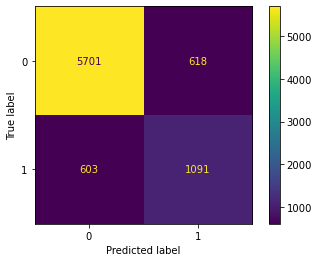

In [40]:
plot_confusion_matrix(best_model_h1n1, X_test, y_test.h1n1_vaccine)
plt.show();

### ROC Curve

In [41]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

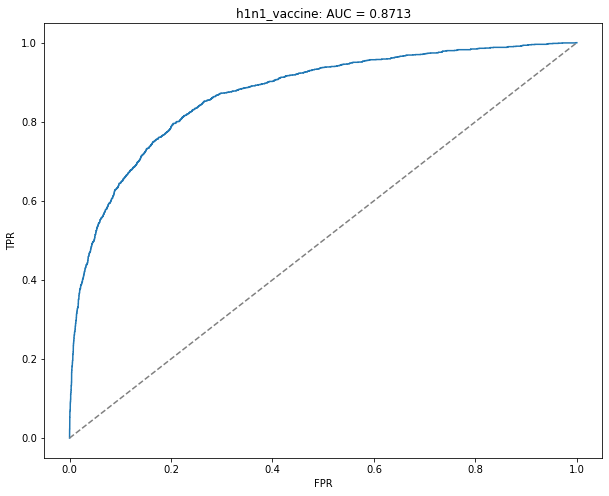

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'], 
    pred_h1n1, 
    'h1n1_vaccine',
    ax=ax
)

## Optuna - Seasonal Vaccine

In [48]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [49]:
def objective2(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength':trial.suggest_int('random_strength', 1,10),
        'bagging_temperature':trial.suggest_int('bagging_temperature', 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        'depth': trial.suggest_int('max_depth', 2,10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        'loss_function': "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [50]:
sampler2 = optuna.samplers.TPESampler(seed=68)
study2 = optuna.create_study(direction="maximize", sampler=sampler2)
study2.optimize(objective2, n_trials=100)

[I 2022-01-27 20:30:27,908] A new study created in memory with name: no-name-34a547f5-f2d9-482c-9df6-50e87a0b1dc8


Training on fold [0/5]

bestTest = 0.4748952616
bestIteration = 609

Training on fold [1/5]

bestTest = 0.4635323442
bestIteration = 620

Training on fold [2/5]

bestTest = 0.4644987313
bestIteration = 520

Training on fold [3/5]

bestTest = 0.4525333453
bestIteration = 729

Training on fold [4/5]


[I 2022-01-27 20:30:44,446] Trial 0 finished with value: 0.8627580850168494 and parameters: {'iterations': 1500, 'learning_rate': 0.029356482739949695, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4637033079
bestIteration = 529

Training on fold [0/5]

bestTest = 0.4771464811
bestIteration = 170

Training on fold [1/5]

bestTest = 0.4628947806
bestIteration = 139

Training on fold [2/5]

bestTest = 0.4672504644
bestIteration = 109

Training on fold [3/5]

bestTest = 0.4549376664
bestIteration = 163

Training on fold [4/5]


[I 2022-01-27 20:30:48,671] Trial 1 finished with value: 0.8611740222191514 and parameters: {'iterations': 200, 'learning_rate': 0.1464067066361795, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4641225589
bestIteration = 128

Training on fold [0/5]

bestTest = 0.4850772406
bestIteration = 53

Training on fold [1/5]

bestTest = 0.4672937142
bestIteration = 79

Training on fold [2/5]

bestTest = 0.4650299945
bestIteration = 80

Training on fold [3/5]

bestTest = 0.4607614963
bestIteration = 62

Training on fold [4/5]


[I 2022-01-27 20:31:05,506] Trial 2 finished with value: 0.8590823235034692 and parameters: {'iterations': 200, 'learning_rate': 0.27287829596201946, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4652331875
bestIteration = 49

Training on fold [0/5]

bestTest = 0.4775745095
bestIteration = 520

Training on fold [1/5]

bestTest = 0.4665665042
bestIteration = 521

Training on fold [2/5]

bestTest = 0.4684350626
bestIteration = 282

Training on fold [3/5]

bestTest = 0.4570215141
bestIteration = 519

Training on fold [4/5]


[I 2022-01-27 20:31:48,662] Trial 3 finished with value: 0.8606738103520618 and parameters: {'iterations': 1200, 'learning_rate': 0.0603209284932487, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4655990405
bestIteration = 536

Training on fold [0/5]

bestTest = 0.4791590112
bestIteration = 88

Training on fold [1/5]

bestTest = 0.4719441984
bestIteration = 64

Training on fold [2/5]

bestTest = 0.4669440659
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4572112713
bestIteration = 96

Training on fold [4/5]


[I 2022-01-27 20:31:51,184] Trial 4 finished with value: 0.8594257413241418 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'max_depth': 4, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4667886462
bestIteration = 56

Training on fold [0/5]

bestTest = 0.5020764782
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4927437615
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4915870289
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4877444123
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 20:31:53,780] Trial 5 finished with value: 0.8498357379274741 and parameters: {'iterations': 100, 'learning_rate': 0.06628011038512191, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4880520278
bestIteration = 99

Training on fold [0/5]

bestTest = 0.482551796
bestIteration = 128

Training on fold [1/5]

bestTest = 0.4633644759
bestIteration = 128

Training on fold [2/5]

bestTest = 0.470313187
bestIteration = 113

Training on fold [3/5]

bestTest = 0.4612752081
bestIteration = 104

Training on fold [4/5]


[I 2022-01-27 20:32:43,449] Trial 6 finished with value: 0.8584395004042653 and parameters: {'iterations': 1200, 'learning_rate': 0.09658215406978513, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 10, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4655649016
bestIteration = 118

Training on fold [0/5]

bestTest = 0.477366831
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4639659695
bestIteration = 114

Training on fold [2/5]

bestTest = 0.4655418245
bestIteration = 120

Training on fold [3/5]

bestTest = 0.457549287
bestIteration = 133

Training on fold [4/5]


[I 2022-01-27 20:32:47,000] Trial 7 finished with value: 0.8611239739553932 and parameters: {'iterations': 500, 'learning_rate': 0.2714096381817127, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4646827757
bestIteration = 124

Training on fold [0/5]

bestTest = 0.4786622074
bestIteration = 125

Training on fold [1/5]

bestTest = 0.467580989
bestIteration = 90

Training on fold [2/5]

bestTest = 0.4673626457
bestIteration = 88

Training on fold [3/5]

bestTest = 0.4559778207
bestIteration = 123

Training on fold [4/5]


[I 2022-01-27 20:32:50,181] Trial 8 finished with value: 0.8592987798960422 and parameters: {'iterations': 1500, 'learning_rate': 0.2053434310118264, 'random_strength': 8, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'max_depth': 3, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4698311916
bestIteration = 73

Training on fold [0/5]

bestTest = 0.4875586496
bestIteration = 29

Training on fold [1/5]

bestTest = 0.4762643189
bestIteration = 39

Training on fold [2/5]

bestTest = 0.47659538
bestIteration = 21

Training on fold [3/5]

bestTest = 0.4693572586
bestIteration = 45

Training on fold [4/5]


[I 2022-01-27 20:33:36,132] Trial 9 finished with value: 0.8542211247023589 and parameters: {'iterations': 100, 'learning_rate': 0.25900665720714294, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 7, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4729975379
bestIteration = 50

Training on fold [0/5]

bestTest = 0.4826327795
bestIteration = 1495

Training on fold [1/5]

bestTest = 0.4711192687
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4751597318
bestIteration = 1371

Training on fold [3/5]

bestTest = 0.4656827279
bestIteration = 1497

Training on fold [4/5]


[I 2022-01-27 20:34:28,762] Trial 10 finished with value: 0.858646654559599 and parameters: {'iterations': 1500, 'learning_rate': 0.006050647464439618, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 6, 'max_depth': 7, 'l2_leaf_reg': 0.007150186521078341, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4687543682
bestIteration = 1495

Training on fold [0/5]

bestTest = 0.4820489868
bestIteration = 107

Training on fold [1/5]

bestTest = 0.4695961622
bestIteration = 118

Training on fold [2/5]

bestTest = 0.4646838003
bestIteration = 111

Training on fold [3/5]

bestTest = 0.4572927967
bestIteration = 100

Training on fold [4/5]


[I 2022-01-27 20:34:33,650] Trial 11 finished with value: 0.8588830117499345 and parameters: {'iterations': 200, 'learning_rate': 0.13750920329129512, 'random_strength': 10, 'bagging_temperature': 4, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.06857418244454487, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4683737821
bestIteration = 107

Training on fold [0/5]

bestTest = 0.4834239839
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4703926808
bestIteration = 91

Training on fold [2/5]

bestTest = 0.4658457411
bestIteration = 87

Training on fold [3/5]

bestTest = 0.4591433679
bestIteration = 85

Training on fold [4/5]


[I 2022-01-27 20:34:37,154] Trial 12 finished with value: 0.8586543273365901 and parameters: {'iterations': 1000, 'learning_rate': 0.16136188689816064, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 0.00013028549097931553, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4668607887
bestIteration = 90

Training on fold [0/5]

bestTest = 0.4878735862
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4792717157
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4756771724
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4725771929
bestIteration = 199

Training on fold [4/5]


[I 2022-01-27 20:34:44,369] Trial 13 finished with value: 0.85679782726342 and parameters: {'iterations': 200, 'learning_rate': 0.015312092326589866, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 6, 'l2_leaf_reg': 0.21656942139045643, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4773935453
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4828377643
bestIteration = 104

Training on fold [1/5]

bestTest = 0.4713406209
bestIteration = 109

Training on fold [2/5]

bestTest = 0.4744546723
bestIteration = 98

Training on fold [3/5]

bestTest = 0.4597730447
bestIteration = 98

Training on fold [4/5]


[I 2022-01-27 20:36:45,137] Trial 14 finished with value: 0.8572509900857804 and parameters: {'iterations': 1500, 'learning_rate': 0.14690216116501453, 'random_strength': 10, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 9, 'l2_leaf_reg': 0.0012700604558864655, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4681899698
bestIteration = 101

Training on fold [0/5]

bestTest = 0.4782071923
bestIteration = 143

Training on fold [1/5]

bestTest = 0.467021288
bestIteration = 164

Training on fold [2/5]

bestTest = 0.4620046656
bestIteration = 170

Training on fold [3/5]

bestTest = 0.4545277016
bestIteration = 153

Training on fold [4/5]


[I 2022-01-27 20:37:09,797] Trial 15 finished with value: 0.8609508641636907 and parameters: {'iterations': 500, 'learning_rate': 0.10902072034609422, 'random_strength': 9, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'max_depth': 4, 'l2_leaf_reg': 9.46314667205651e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4661948129
bestIteration = 161

Training on fold [0/5]

bestTest = 0.4784425806
bestIteration = 103

Training on fold [1/5]

bestTest = 0.4665572667
bestIteration = 108

Training on fold [2/5]

bestTest = 0.4676947113
bestIteration = 89

Training on fold [3/5]

bestTest = 0.4559436083
bestIteration = 124

Training on fold [4/5]


[I 2022-01-27 20:37:12,832] Trial 16 finished with value: 0.8603481538249709 and parameters: {'iterations': 300, 'learning_rate': 0.18724782574165397, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 3, 'l2_leaf_reg': 0.002044181008008903, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8627580850168494.



bestTest = 0.4650553299
bestIteration = 142

Training on fold [0/5]

bestTest = 0.4749212253
bestIteration = 329

Training on fold [1/5]

bestTest = 0.4635231471
bestIteration = 334

Training on fold [2/5]

bestTest = 0.460528606
bestIteration = 352

Training on fold [3/5]

bestTest = 0.4507803849
bestIteration = 416

Training on fold [4/5]


[I 2022-01-27 20:37:24,934] Trial 17 finished with value: 0.8631714834013792 and parameters: {'iterations': 1000, 'learning_rate': 0.049633505636177605, 'random_strength': 9, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 0.4780668252251499, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 17 with value: 0.8631714834013792.



bestTest = 0.4606393565
bestIteration = 290

Training on fold [0/5]

bestTest = 0.4730461685
bestIteration = 421

Training on fold [1/5]

bestTest = 0.4633375647
bestIteration = 380

Training on fold [2/5]

bestTest = 0.4613829303
bestIteration = 426

Training on fold [3/5]

bestTest = 0.4502674884
bestIteration = 548

Training on fold [4/5]


[I 2022-01-27 20:37:45,606] Trial 18 finished with value: 0.8641042075455369 and parameters: {'iterations': 1000, 'learning_rate': 0.040343063238085314, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'max_depth': 8, 'l2_leaf_reg': 87.51650927197507, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.4592782971
bestIteration = 448

Training on fold [0/5]

bestTest = 0.4721585093
bestIteration = 354

Training on fold [1/5]

bestTest = 0.4623671663
bestIteration = 334

Training on fold [2/5]

bestTest = 0.4626100813
bestIteration = 343

Training on fold [3/5]

bestTest = 0.4508784715
bestIteration = 419

Training on fold [4/5]


[I 2022-01-27 20:38:02,919] Trial 19 finished with value: 0.8638564070722827 and parameters: {'iterations': 1000, 'learning_rate': 0.05235643959322728, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 99.11695455168547, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.4599893048
bestIteration = 322

Training on fold [0/5]

bestTest = 0.4739774034
bestIteration = 166

Training on fold [1/5]

bestTest = 0.4617594557
bestIteration = 195

Training on fold [2/5]

bestTest = 0.4618301291
bestIteration = 179

Training on fold [3/5]

bestTest = 0.4545295079
bestIteration = 150

Training on fold [4/5]


[I 2022-01-27 20:38:12,027] Trial 20 finished with value: 0.8634330226542218 and parameters: {'iterations': 1000, 'learning_rate': 0.09513730589371244, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 90.56559174112061, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.4604473951
bestIteration = 167

Training on fold [0/5]

bestTest = 0.4729144591
bestIteration = 177

Training on fold [1/5]

bestTest = 0.4623367038
bestIteration = 201

Training on fold [2/5]

bestTest = 0.460244771
bestIteration = 245

Training on fold [3/5]

bestTest = 0.4509554178
bestIteration = 218

Training on fold [4/5]


[I 2022-01-27 20:38:22,331] Trial 21 finished with value: 0.8638930565420887 and parameters: {'iterations': 1000, 'learning_rate': 0.09441898044121402, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'max_depth': 8, 'l2_leaf_reg': 98.73471636156114, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.4607724896
bestIteration = 182

Training on fold [0/5]

bestTest = 0.4739687977
bestIteration = 207

Training on fold [1/5]

bestTest = 0.4628342627
bestIteration = 213

Training on fold [2/5]

bestTest = 0.4620078841
bestIteration = 224

Training on fold [3/5]

bestTest = 0.4503564781
bestIteration = 274

Training on fold [4/5]


[I 2022-01-27 20:38:36,482] Trial 22 finished with value: 0.8632808189444248 and parameters: {'iterations': 1000, 'learning_rate': 0.07688467875886079, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 91.69888044928044, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.463113335
bestIteration = 226

Training on fold [0/5]

bestTest = 0.4739771821
bestIteration = 344

Training on fold [1/5]

bestTest = 0.462731463
bestIteration = 422

Training on fold [2/5]

bestTest = 0.460766233
bestIteration = 372

Training on fold [3/5]

bestTest = 0.4506518166
bestIteration = 406

Training on fold [4/5]


[I 2022-01-27 20:38:55,029] Trial 23 finished with value: 0.86379915971164 and parameters: {'iterations': 1000, 'learning_rate': 0.04005862366031986, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'max_depth': 8, 'l2_leaf_reg': 16.318715042880733, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.460753233
bestIteration = 360

Training on fold [0/5]

bestTest = 0.4833432886
bestIteration = 69

Training on fold [1/5]

bestTest = 0.4676300075
bestIteration = 92

Training on fold [2/5]

bestTest = 0.4702159828
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4543314676
bestIteration = 118

Training on fold [4/5]


[I 2022-01-27 20:39:00,910] Trial 24 finished with value: 0.8595104702556275 and parameters: {'iterations': 1000, 'learning_rate': 0.11612659206343381, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 5, 'max_depth': 8, 'l2_leaf_reg': 1.21575619956532, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.4643379327
bestIteration = 128

Training on fold [0/5]

bestTest = 0.4755329424
bestIteration = 164

Training on fold [1/5]

bestTest = 0.4655922374
bestIteration = 166

Training on fold [2/5]

bestTest = 0.4630070103
bestIteration = 222

Training on fold [3/5]

bestTest = 0.45027909
bestIteration = 212

Training on fold [4/5]


[I 2022-01-27 20:39:16,363] Trial 25 finished with value: 0.8628473158611143 and parameters: {'iterations': 1000, 'learning_rate': 0.0790212971445058, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 7, 'max_depth': 10, 'l2_leaf_reg': 24.626076631537728, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 18 with value: 0.8641042075455369.



bestTest = 0.4598101146
bestIteration = 163

Training on fold [0/5]

bestTest = 0.4724740395
bestIteration = 481

Training on fold [1/5]

bestTest = 0.4610224434
bestIteration = 560

Training on fold [2/5]

bestTest = 0.461652193
bestIteration = 451

Training on fold [3/5]

bestTest = 0.4503963552
bestIteration = 568

Training on fold [4/5]


[I 2022-01-27 20:39:43,186] Trial 26 finished with value: 0.8643163209172358 and parameters: {'iterations': 1000, 'learning_rate': 0.029825923096093006, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 96.07024350178433, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 26 with value: 0.8643163209172358.



bestTest = 0.4602416847
bestIteration = 476

Training on fold [0/5]

bestTest = 0.4734473628
bestIteration = 514

Training on fold [1/5]

bestTest = 0.4614885195
bestIteration = 567

Training on fold [2/5]

bestTest = 0.4644399223
bestIteration = 388

Training on fold [3/5]

bestTest = 0.4498991604
bestIteration = 476

Training on fold [4/5]


[I 2022-01-27 20:48:05,393] Trial 27 finished with value: 0.8638223629017556 and parameters: {'iterations': 1000, 'learning_rate': 0.024578990218377034, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 7, 'l2_leaf_reg': 4.221458204769845, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 26 with value: 0.8643163209172358.



bestTest = 0.4608138273
bestIteration = 503

Training on fold [0/5]

bestTest = 0.4853544619
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4767482477
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4744012869
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4680316693
bestIteration = 999

Training on fold [4/5]


[I 2022-01-27 21:02:47,066] Trial 28 finished with value: 0.8585647212843306 and parameters: {'iterations': 1000, 'learning_rate': 0.00558037108948542, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 6, 'l2_leaf_reg': 0.47230055820807965, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 26 with value: 0.8643163209172358.



bestTest = 0.4747990779
bestIteration = 999

Training on fold [0/5]

bestTest = 0.4713079697
bestIteration = 533

Training on fold [1/5]

bestTest = 0.4623970813
bestIteration = 446

Training on fold [2/5]

bestTest = 0.4612075706
bestIteration = 459

Training on fold [3/5]

bestTest = 0.4511521597
bestIteration = 503

Training on fold [4/5]


[I 2022-01-27 21:03:13,413] Trial 29 finished with value: 0.8640815107906533 and parameters: {'iterations': 1000, 'learning_rate': 0.032747749334154246, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 18.57962015993573, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 26 with value: 0.8643163209172358.



bestTest = 0.4605626243
bestIteration = 429

Training on fold [0/5]

bestTest = 0.4724510367
bestIteration = 514

Training on fold [1/5]

bestTest = 0.4606802758
bestIteration = 411

Training on fold [2/5]

bestTest = 0.4619566685
bestIteration = 351

Training on fold [3/5]

bestTest = 0.4486409331
bestIteration = 428

Training on fold [4/5]


[I 2022-01-27 21:11:03,370] Trial 30 finished with value: 0.864686573317728 and parameters: {'iterations': 1200, 'learning_rate': 0.03327815917148751, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 13.041650670725405, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4599300398
bestIteration = 359

Training on fold [0/5]

bestTest = 0.4727472552
bestIteration = 441

Training on fold [1/5]

bestTest = 0.4630922013
bestIteration = 445

Training on fold [2/5]

bestTest = 0.4615031201
bestIteration = 452

Training on fold [3/5]

bestTest = 0.4484945413
bestIteration = 450

Training on fold [4/5]


[I 2022-01-27 21:19:42,896] Trial 31 finished with value: 0.8641535930764295 and parameters: {'iterations': 1200, 'learning_rate': 0.02648745798698701, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 14.475515503203349, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4619671133
bestIteration = 401

Training on fold [0/5]

bestTest = 0.4748706379
bestIteration = 348

Training on fold [1/5]

bestTest = 0.4628243098
bestIteration = 359

Training on fold [2/5]

bestTest = 0.4647751894
bestIteration = 268

Training on fold [3/5]

bestTest = 0.4487926088
bestIteration = 423

Training on fold [4/5]


[I 2022-01-27 21:26:21,373] Trial 32 finished with value: 0.86345694240632 and parameters: {'iterations': 1200, 'learning_rate': 0.02994248807416655, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 9, 'l2_leaf_reg': 1.7913285499878862, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4625002645
bestIteration = 310

Training on fold [0/5]

bestTest = 0.5080486631
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5033598047
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4976920166
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4962335017
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-27 21:50:22,333] Trial 33 finished with value: 0.8516549860288368 and parameters: {'iterations': 1200, 'learning_rate': 0.0017867322227078791, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 9.027942246539478, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.499704131
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4745292981
bestIteration = 286

Training on fold [1/5]

bestTest = 0.4636861248
bestIteration = 303

Training on fold [2/5]

bestTest = 0.462470602
bestIteration = 293

Training on fold [3/5]

bestTest = 0.4497817013
bestIteration = 334

Training on fold [4/5]


[I 2022-01-27 21:55:44,259] Trial 34 finished with value: 0.863292546332054 and parameters: {'iterations': 1200, 'learning_rate': 0.041363109346287605, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 0.09256479550926446, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4619228392
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4735253687
bestIteration = 212

Training on fold [1/5]

bestTest = 0.4615463591
bestIteration = 239

Training on fold [2/5]

bestTest = 0.4618102999
bestIteration = 200

Training on fold [3/5]

bestTest = 0.4467348591
bestIteration = 253

Training on fold [4/5]


[I 2022-01-27 22:00:00,318] Trial 35 finished with value: 0.8641440142338679 and parameters: {'iterations': 1200, 'learning_rate': 0.06863573826556611, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 30.683309539186073, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4608078643
bestIteration = 210

Training on fold [0/5]

bestTest = 0.4756859328
bestIteration = 224

Training on fold [1/5]

bestTest = 0.4668973862
bestIteration = 217

Training on fold [2/5]

bestTest = 0.4638157314
bestIteration = 204

Training on fold [3/5]

bestTest = 0.4493143922
bestIteration = 242

Training on fold [4/5]


[I 2022-01-27 22:04:23,791] Trial 36 finished with value: 0.862448270132733 and parameters: {'iterations': 1200, 'learning_rate': 0.05870117345185181, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 0.0179020414048635, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4635620627
bestIteration = 241

Training on fold [0/5]

bestTest = 0.473496007
bestIteration = 206

Training on fold [1/5]

bestTest = 0.4642416566
bestIteration = 183

Training on fold [2/5]

bestTest = 0.4653642256
bestIteration = 181

Training on fold [3/5]

bestTest = 0.4489143652
bestIteration = 236

Training on fold [4/5]


[I 2022-01-27 22:08:25,068] Trial 37 finished with value: 0.8624251992605185 and parameters: {'iterations': 1200, 'learning_rate': 0.07259644446472877, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 1.4651712481369712, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4640158513
bestIteration = 178

Training on fold [0/5]

bestTest = 0.4732624198
bestIteration = 455

Training on fold [1/5]

bestTest = 0.4625680941
bestIteration = 461

Training on fold [2/5]

bestTest = 0.4621801146
bestIteration = 375

Training on fold [3/5]

bestTest = 0.451161463
bestIteration = 424

Training on fold [4/5]


[I 2022-01-27 22:17:31,451] Trial 38 finished with value: 0.8640014774638745 and parameters: {'iterations': 1200, 'learning_rate': 0.02434607134933131, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 9, 'l2_leaf_reg': 25.083490671320504, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4615543206
bestIteration = 458

Training on fold [0/5]

bestTest = 0.4800438056
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4695741805
bestIteration = 140

Training on fold [2/5]

bestTest = 0.4687551871
bestIteration = 118

Training on fold [3/5]

bestTest = 0.455738705
bestIteration = 202

Training on fold [4/5]


[I 2022-01-27 22:20:32,392] Trial 39 finished with value: 0.8590031751409504 and parameters: {'iterations': 1200, 'learning_rate': 0.06372749946631942, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 10, 'l2_leaf_reg': 8.481028134568822e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4720434838
bestIteration = 120

Training on fold [0/5]

bestTest = 0.5271995068
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5249571741
bestIteration = 99

Training on fold [2/5]

bestTest = 0.520086311
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5192253986
bestIteration = 99

Training on fold [4/5]


[I 2022-01-27 22:22:30,429] Trial 40 finished with value: 0.8452351262889811 and parameters: {'iterations': 100, 'learning_rate': 0.017179431909549424, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_depth': 9, 'l2_leaf_reg': 5.411496559560248, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.5213121807
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4755257333
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4632383463
bestIteration = 298

Training on fold [2/5]

bestTest = 0.4625098214
bestIteration = 298

Training on fold [3/5]

bestTest = 0.4511090051
bestIteration = 299

Training on fold [4/5]


[I 2022-01-27 22:28:08,150] Trial 41 finished with value: 0.8634485320144861 and parameters: {'iterations': 300, 'learning_rate': 0.0398098748447933, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 25.827804615511532, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4613377141
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4734929377
bestIteration = 204

Training on fold [1/5]

bestTest = 0.465580212
bestIteration = 159

Training on fold [2/5]

bestTest = 0.4605779606
bestIteration = 167

Training on fold [3/5]

bestTest = 0.4521332406
bestIteration = 149

Training on fold [4/5]


[I 2022-01-27 22:28:18,178] Trial 42 finished with value: 0.8632679301972079 and parameters: {'iterations': 1200, 'learning_rate': 0.0846894874710125, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 7, 'l2_leaf_reg': 46.114993267961935, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4598432912
bestIteration = 164

Training on fold [0/5]

bestTest = 0.4761345612
bestIteration = 163

Training on fold [1/5]

bestTest = 0.4650188885
bestIteration = 177

Training on fold [2/5]

bestTest = 0.4635775678
bestIteration = 195

Training on fold [3/5]

bestTest = 0.4499577168
bestIteration = 226

Training on fold [4/5]


[I 2022-01-27 22:32:14,358] Trial 43 finished with value: 0.8625718963011811 and parameters: {'iterations': 500, 'learning_rate': 0.05227754836330724, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 8, 'l2_leaf_reg': 3.8954534665799123, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4648108961
bestIteration = 200

Training on fold [0/5]

bestTest = 0.4738255446
bestIteration = 827

Training on fold [1/5]

bestTest = 0.4600606034
bestIteration = 981

Training on fold [2/5]

bestTest = 0.4618141346
bestIteration = 860

Training on fold [3/5]

bestTest = 0.4482892644
bestIteration = 947

Training on fold [4/5]


[I 2022-01-27 22:50:17,213] Trial 44 finished with value: 0.86433816239864 and parameters: {'iterations': 1200, 'learning_rate': 0.016791800283916067, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 9, 'l2_leaf_reg': 7.360970579561716, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4607574296
bestIteration = 861

Training on fold [0/5]

bestTest = 0.4934174017
bestIteration = 27

Training on fold [1/5]

bestTest = 0.4853055166
bestIteration = 46

Training on fold [2/5]

bestTest = 0.4860601881
bestIteration = 30

Training on fold [3/5]

bestTest = 0.4730001363
bestIteration = 42

Training on fold [4/5]


[I 2022-01-27 22:51:10,036] Trial 45 finished with value: 0.849827253210016 and parameters: {'iterations': 1200, 'learning_rate': 0.29311363349234243, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 4, 'max_depth': 10, 'l2_leaf_reg': 2.198287698694986e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4857212473
bestIteration = 30

Training on fold [0/5]

bestTest = 0.4738912418
bestIteration = 933

Training on fold [1/5]

bestTest = 0.4619665821
bestIteration = 841

Training on fold [2/5]

bestTest = 0.4632790091
bestIteration = 818

Training on fold [3/5]

bestTest = 0.4499529173
bestIteration = 931

Training on fold [4/5]


[I 2022-01-27 23:07:15,411] Trial 46 finished with value: 0.8637803205801292 and parameters: {'iterations': 1200, 'learning_rate': 0.015230621445488748, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 8, 'max_depth': 9, 'l2_leaf_reg': 0.5281937161863496, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4611173531
bestIteration = 830

Training on fold [0/5]

bestTest = 0.4739601637
bestIteration = 838

Training on fold [1/5]

bestTest = 0.4615170365
bestIteration = 916

Training on fold [2/5]

bestTest = 0.4628992072
bestIteration = 835

Training on fold [3/5]

bestTest = 0.4492293323
bestIteration = 934

Training on fold [4/5]


[I 2022-01-27 23:23:15,884] Trial 47 finished with value: 0.8640814498132683 and parameters: {'iterations': 1200, 'learning_rate': 0.015586726218536616, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 10, 'max_depth': 10, 'l2_leaf_reg': 10.072729883914304, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4599408524
bestIteration = 954

Training on fold [0/5]

bestTest = 0.4813464936
bestIteration = 45

Training on fold [1/5]

bestTest = 0.4761199539
bestIteration = 43

Training on fold [2/5]

bestTest = 0.4700122197
bestIteration = 52

Training on fold [3/5]

bestTest = 0.457036923
bestIteration = 55

Training on fold [4/5]


[I 2022-01-27 23:23:18,686] Trial 48 finished with value: 0.8584254278214682 and parameters: {'iterations': 200, 'learning_rate': 0.24019078061698435, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 9, 'max_depth': 5, 'l2_leaf_reg': 0.13948111204478048, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4637064352
bestIteration = 46

Training on fold [0/5]

bestTest = 0.4757860733
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4632799328
bestIteration = 103

Training on fold [2/5]

bestTest = 0.4673975697
bestIteration = 106

Training on fold [3/5]

bestTest = 0.4537548851
bestIteration = 124

Training on fold [4/5]


[I 2022-01-27 23:25:26,631] Trial 49 finished with value: 0.8615289431074021 and parameters: {'iterations': 1500, 'learning_rate': 0.11888086890171645, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 9, 'l2_leaf_reg': 0.90865161074192, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4638436699
bestIteration = 102

Training on fold [0/5]

bestTest = 0.4783919488
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4680379573
bestIteration = 99

Training on fold [2/5]

bestTest = 0.465330764
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4568597252
bestIteration = 97

Training on fold [4/5]


[I 2022-01-27 23:25:31,301] Trial 50 finished with value: 0.861125652683263 and parameters: {'iterations': 100, 'learning_rate': 0.05933833496314449, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 8, 'max_depth': 6, 'l2_leaf_reg': 0.031542943430290654, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4641459719
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4737117605
bestIteration = 431

Training on fold [1/5]

bestTest = 0.4604889849
bestIteration = 512

Training on fold [2/5]

bestTest = 0.4630767651
bestIteration = 414

Training on fold [3/5]

bestTest = 0.4474643461
bestIteration = 507

Training on fold [4/5]


[I 2022-01-27 23:32:54,071] Trial 51 finished with value: 0.864262299029116 and parameters: {'iterations': 1200, 'learning_rate': 0.035598015592911404, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 34.13882658414394, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4603077139
bestIteration = 410

Training on fold [0/5]

bestTest = 0.473606609
bestIteration = 481

Training on fold [1/5]

bestTest = 0.4611325445
bestIteration = 567

Training on fold [2/5]

bestTest = 0.4613954926
bestIteration = 451

Training on fold [3/5]

bestTest = 0.4482299434
bestIteration = 572

Training on fold [4/5]


[I 2022-01-27 23:41:25,888] Trial 52 finished with value: 0.8642749363813591 and parameters: {'iterations': 1200, 'learning_rate': 0.031142977388475164, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 8.434707421309485, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4606457521
bestIteration = 534

Training on fold [0/5]

bestTest = 0.4755047115
bestIteration = 447

Training on fold [1/5]

bestTest = 0.4606743415
bestIteration = 547

Training on fold [2/5]

bestTest = 0.4621374045
bestIteration = 477

Training on fold [3/5]

bestTest = 0.4485767509
bestIteration = 532

Training on fold [4/5]


[I 2022-01-27 23:49:45,924] Trial 53 finished with value: 0.8639541202916614 and parameters: {'iterations': 1200, 'learning_rate': 0.02916325275444845, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 7.647542032524411, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4609662062
bestIteration = 546

Training on fold [0/5]

bestTest = 0.4787766967
bestIteration = 93

Training on fold [1/5]

bestTest = 0.4664498257
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4660741126
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4497879227
bestIteration = 89

Training on fold [4/5]


[I 2022-01-27 23:51:14,722] Trial 54 finished with value: 0.8611902893974273 and parameters: {'iterations': 1200, 'learning_rate': 0.17853282635418055, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 2.951700161584236, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4650920753
bestIteration = 88

Training on fold [0/5]

bestTest = 0.5719187794
bestIteration = 299

Training on fold [1/5]

bestTest = 0.5705459998
bestIteration = 299

Training on fold [2/5]

bestTest = 0.5662257769
bestIteration = 299

Training on fold [3/5]

bestTest = 0.5661535043
bestIteration = 299

Training on fold [4/5]


[I 2022-01-27 23:56:03,590] Trial 55 finished with value: 0.8390592204445524 and parameters: {'iterations': 300, 'learning_rate': 0.0028403632212096533, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 8.684977624043376e-05, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.5680002792
bestIteration = 299

Training on fold [0/5]

bestTest = 0.4765359587
bestIteration = 253

Training on fold [1/5]

bestTest = 0.4629446165
bestIteration = 292

Training on fold [2/5]

bestTest = 0.4639203814
bestIteration = 266

Training on fold [3/5]

bestTest = 0.4497696162
bestIteration = 334

Training on fold [4/5]


[I 2022-01-28 00:00:44,513] Trial 56 finished with value: 0.8628378710698813 and parameters: {'iterations': 500, 'learning_rate': 0.04747412864669813, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 0.26374245569229743, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4618167737
bestIteration = 305

Training on fold [0/5]

bestTest = 0.4732363536
bestIteration = 960

Training on fold [1/5]

bestTest = 0.4616739117
bestIteration = 1049

Training on fold [2/5]

bestTest = 0.4609470394
bestIteration = 934

Training on fold [3/5]

bestTest = 0.4488252622
bestIteration = 1063

Training on fold [4/5]


[I 2022-01-28 00:04:02,490] Trial 57 finished with value: 0.8642672007956019 and parameters: {'iterations': 1200, 'learning_rate': 0.015252651695262225, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 39.17354329853966, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4613745713
bestIteration = 946

Training on fold [0/5]

bestTest = 0.5015250726
bestIteration = 199

Training on fold [1/5]

bestTest = 0.494320991
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4909918185
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4901886612
bestIteration = 199

Training on fold [4/5]


[I 2022-01-28 00:04:43,007] Trial 58 finished with value: 0.8536535757979173 and parameters: {'iterations': 200, 'learning_rate': 0.017636822120497407, 'random_strength': 8, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 44.97532608948053, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4918669081
bestIteration = 199

Training on fold [0/5]

bestTest = 0.473486597
bestIteration = 426

Training on fold [1/5]

bestTest = 0.4605638229
bestIteration = 511

Training on fold [2/5]

bestTest = 0.4605417439
bestIteration = 407

Training on fold [3/5]

bestTest = 0.4506286082
bestIteration = 472

Training on fold [4/5]


[I 2022-01-28 00:06:02,651] Trial 59 finished with value: 0.8637340618712184 and parameters: {'iterations': 1200, 'learning_rate': 0.0351567207117684, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 45.13167293562861, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4620705019
bestIteration = 487

Training on fold [0/5]

bestTest = 0.4721738887
bestIteration = 379

Training on fold [1/5]

bestTest = 0.4638815001
bestIteration = 300

Training on fold [2/5]

bestTest = 0.4614290152
bestIteration = 328

Training on fold [3/5]

bestTest = 0.4507035754
bestIteration = 359

Training on fold [4/5]


[I 2022-01-28 00:06:15,012] Trial 60 finished with value: 0.863588763493879 and parameters: {'iterations': 1500, 'learning_rate': 0.04744746650939494, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 7.469552841255809, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4619014896
bestIteration = 283

Training on fold [0/5]

bestTest = 0.4748080341
bestIteration = 508

Training on fold [1/5]

bestTest = 0.462390888
bestIteration = 532

Training on fold [2/5]

bestTest = 0.4625366907
bestIteration = 474

Training on fold [3/5]

bestTest = 0.4472764002
bestIteration = 624

Training on fold [4/5]


[I 2022-01-28 00:08:48,721] Trial 61 finished with value: 0.8639442062612357 and parameters: {'iterations': 1200, 'learning_rate': 0.024003818419117126, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 10.590648661411212, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4600903621
bestIteration = 583

Training on fold [0/5]

bestTest = 0.4730531919
bestIteration = 997

Training on fold [1/5]

bestTest = 0.4611853024
bestIteration = 982

Training on fold [2/5]

bestTest = 0.4615762017
bestIteration = 942

Training on fold [3/5]

bestTest = 0.4469877815
bestIteration = 1152

Training on fold [4/5]


[I 2022-01-28 00:12:15,060] Trial 62 finished with value: 0.864388042831669 and parameters: {'iterations': 1200, 'learning_rate': 0.013714161653611391, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 3.06949824799466, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4619269064
bestIteration = 952

Training on fold [0/5]

bestTest = 0.4725642896
bestIteration = 1038

Training on fold [1/5]

bestTest = 0.4625698573
bestIteration = 948

Training on fold [2/5]

bestTest = 0.4610723335
bestIteration = 1047

Training on fold [3/5]

bestTest = 0.4503309875
bestIteration = 1042

Training on fold [4/5]


[I 2022-01-28 00:12:59,502] Trial 63 finished with value: 0.8643890211331046 and parameters: {'iterations': 1200, 'learning_rate': 0.013297820525381913, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 2.915526481537167, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4593044112
bestIteration = 948

Training on fold [0/5]

bestTest = 0.4763075086
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4663234948
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4647175928
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4558507003
bestIteration = 1198

Training on fold [4/5]


[I 2022-01-28 00:13:53,959] Trial 64 finished with value: 0.8624746780049382 and parameters: {'iterations': 1200, 'learning_rate': 0.008338664494511941, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 2.658047084732864, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4624558101
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4739297066
bestIteration = 1099

Training on fold [1/5]

bestTest = 0.4646808639
bestIteration = 989

Training on fold [2/5]

bestTest = 0.4628641434
bestIteration = 1048

Training on fold [3/5]

bestTest = 0.4514563889
bestIteration = 1196

Training on fold [4/5]


[I 2022-01-28 00:14:33,207] Trial 65 finished with value: 0.8634719173610851 and parameters: {'iterations': 1200, 'learning_rate': 0.012714763507780297, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 5, 'l2_leaf_reg': 0.7549271422300431, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4607102961
bestIteration = 1016

Training on fold [0/5]

bestTest = 0.5260003757
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5219587912
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.5184289817
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5165626162
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-28 00:15:29,437] Trial 66 finished with value: 0.8476658573743585 and parameters: {'iterations': 1200, 'learning_rate': 0.0013644550920860702, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 2.127898520185956, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.5172712355
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.5125243701
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5085356446
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5035895783
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5014002771
bestIteration = 99

Training on fold [4/5]


[I 2022-01-28 00:15:34,363] Trial 67 finished with value: 0.8496748133980139 and parameters: {'iterations': 100, 'learning_rate': 0.020382122341271923, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 4.379802154372252, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.5021384016
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4712328083
bestIteration = 481

Training on fold [1/5]

bestTest = 0.4628676075
bestIteration = 372

Training on fold [2/5]

bestTest = 0.460660504
bestIteration = 450

Training on fold [3/5]

bestTest = 0.4485848138
bestIteration = 501

Training on fold [4/5]


[I 2022-01-28 00:16:38,850] Trial 68 finished with value: 0.8641610530320977 and parameters: {'iterations': 1200, 'learning_rate': 0.04462162461002667, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 4, 'l2_leaf_reg': 51.069558821580586, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4606535267
bestIteration = 414

Training on fold [0/5]

bestTest = 0.4777171456
bestIteration = 270

Training on fold [1/5]

bestTest = 0.4658867852
bestIteration = 245

Training on fold [2/5]

bestTest = 0.4661844657
bestIteration = 230

Training on fold [3/5]

bestTest = 0.454039381
bestIteration = 248

Training on fold [4/5]


[I 2022-01-28 00:16:48,697] Trial 69 finished with value: 0.861522144589812 and parameters: {'iterations': 300, 'learning_rate': 0.0554363427855875, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 5, 'l2_leaf_reg': 0.005520754516234163, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4625969058
bestIteration = 239

Training on fold [0/5]

bestTest = 0.4762342253
bestIteration = 133

Training on fold [1/5]

bestTest = 0.4663463251
bestIteration = 145

Training on fold [2/5]

bestTest = 0.4648735723
bestIteration = 101

Training on fold [3/5]

bestTest = 0.4575409367
bestIteration = 106

Training on fold [4/5]


[I 2022-01-28 00:17:22,228] Trial 70 finished with value: 0.8606627700741267 and parameters: {'iterations': 500, 'learning_rate': 0.08607594248754032, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 0.3307769269611679, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.466779889
bestIteration = 137

Training on fold [0/5]

bestTest = 0.4710372627
bestIteration = 541

Training on fold [1/5]

bestTest = 0.4604506881
bestIteration = 522

Training on fold [2/5]

bestTest = 0.4617840064
bestIteration = 440

Training on fold [3/5]

bestTest = 0.4484066942
bestIteration = 560

Training on fold [4/5]


[I 2022-01-28 00:19:08,117] Trial 71 finished with value: 0.8643127216131556 and parameters: {'iterations': 1200, 'learning_rate': 0.03082956518580488, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 25.000147553369537, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4631775006
bestIteration = 482

Training on fold [0/5]

bestTest = 0.4755334706
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4651952777
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.462803259
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4538396403
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-28 00:23:13,423] Trial 72 finished with value: 0.8628118270300043 and parameters: {'iterations': 1200, 'learning_rate': 0.009767004455836004, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 13.050989155883451, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4633236401
bestIteration = 1198

Training on fold [0/5]

bestTest = 0.4822790064
bestIteration = 293

Training on fold [1/5]

bestTest = 0.4653986879
bestIteration = 441

Training on fold [2/5]

bestTest = 0.4684133966
bestIteration = 335

Training on fold [3/5]

bestTest = 0.4498211847
bestIteration = 525

Training on fold [4/5]


[I 2022-01-28 00:24:39,831] Trial 73 finished with value: 0.8610125175278389 and parameters: {'iterations': 1200, 'learning_rate': 0.02841856379000718, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 0.0002818568723271996, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4652216208
bestIteration = 431

Training on fold [0/5]

bestTest = 0.472974628
bestIteration = 418

Training on fold [1/5]

bestTest = 0.4625491596
bestIteration = 472

Training on fold [2/5]

bestTest = 0.4614976759
bestIteration = 437

Training on fold [3/5]

bestTest = 0.4501823497
bestIteration = 425

Training on fold [4/5]


[I 2022-01-28 00:24:57,665] Trial 74 finished with value: 0.8638744781853639 and parameters: {'iterations': 1200, 'learning_rate': 0.03570717976180122, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 19.34927724081019, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4615835278
bestIteration = 390

Training on fold [0/5]

bestTest = 0.4736040324
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4614516729
bestIteration = 1195

Training on fold [2/5]

bestTest = 0.4625171775
bestIteration = 1191

Training on fold [3/5]

bestTest = 0.4491156026
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-28 00:29:17,252] Trial 75 finished with value: 0.8640793162308491 and parameters: {'iterations': 1200, 'learning_rate': 0.011099516034615009, 'random_strength': 5, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 1.1593653615036963, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4607861442
bestIteration = 1173

Training on fold [0/5]

bestTest = 0.4713690082
bestIteration = 767

Training on fold [1/5]

bestTest = 0.4623431426
bestIteration = 772

Training on fold [2/5]

bestTest = 0.4614732701
bestIteration = 651

Training on fold [3/5]

bestTest = 0.4479738901
bestIteration = 815

Training on fold [4/5]


[I 2022-01-28 00:32:25,476] Trial 76 finished with value: 0.8645132551962877 and parameters: {'iterations': 1200, 'learning_rate': 0.02101421554297829, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 94.20252220385441, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4604670632
bestIteration = 740

Training on fold [0/5]

bestTest = 0.4752465297
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4636647174
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4629938328
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4536392905
bestIteration = 199

Training on fold [4/5]


[I 2022-01-28 00:33:14,367] Trial 77 finished with value: 0.8627977388767499 and parameters: {'iterations': 200, 'learning_rate': 0.06522435329080624, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 98.09585416488612, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.463200572
bestIteration = 199

Training on fold [0/5]

bestTest = 0.4810648501
bestIteration = 86

Training on fold [1/5]

bestTest = 0.4663504143
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4663845587
bestIteration = 101

Training on fold [3/5]

bestTest = 0.4542546648
bestIteration = 103

Training on fold [4/5]


[I 2022-01-28 00:33:45,609] Trial 78 finished with value: 0.860134799670492 and parameters: {'iterations': 1200, 'learning_rate': 0.13669251706445654, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 8, 'l2_leaf_reg': 6.86324071992244, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4652282686
bestIteration = 98

Training on fold [0/5]

bestTest = 0.4722639285
bestIteration = 621

Training on fold [1/5]

bestTest = 0.4629768266
bestIteration = 564

Training on fold [2/5]

bestTest = 0.4609324945
bestIteration = 538

Training on fold [3/5]

bestTest = 0.4506110337
bestIteration = 582

Training on fold [4/5]


[I 2022-01-28 00:34:19,840] Trial 79 finished with value: 0.8641977233973341 and parameters: {'iterations': 1500, 'learning_rate': 0.024747063770905055, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 63.41357412156209, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4599508962
bestIteration = 581

Training on fold [0/5]

bestTest = 0.4718848233
bestIteration = 399

Training on fold [1/5]

bestTest = 0.461816963
bestIteration = 352

Training on fold [2/5]

bestTest = 0.4608863842
bestIteration = 346

Training on fold [3/5]

bestTest = 0.4480037678
bestIteration = 392

Training on fold [4/5]


[I 2022-01-28 00:35:53,119] Trial 80 finished with value: 0.8636715091972308 and parameters: {'iterations': 1200, 'learning_rate': 0.04291955386888478, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 7, 'l2_leaf_reg': 18.435343406651487, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4625656751
bestIteration = 356

Training on fold [0/5]

bestTest = 0.4725225124
bestIteration = 792

Training on fold [1/5]

bestTest = 0.4612406013
bestIteration = 782

Training on fold [2/5]

bestTest = 0.4604943475
bestIteration = 746

Training on fold [3/5]

bestTest = 0.4475479557
bestIteration = 749

Training on fold [4/5]


[I 2022-01-28 00:38:31,695] Trial 81 finished with value: 0.8644627336712369 and parameters: {'iterations': 1200, 'learning_rate': 0.02003403251138426, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 26.64783221412401, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4620869745
bestIteration = 779

Training on fold [0/5]

bestTest = 0.4735806446
bestIteration = 428

Training on fold [1/5]

bestTest = 0.4581897024
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4626921605
bestIteration = 407

Training on fold [3/5]

bestTest = 0.4473627644
bestIteration = 493

Training on fold [4/5]


[I 2022-01-28 00:40:06,085] Trial 82 finished with value: 0.8643123452923241 and parameters: {'iterations': 1200, 'learning_rate': 0.034231012190060625, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 6, 'l2_leaf_reg': 4.164866192470023, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.461390987
bestIteration = 415

Training on fold [0/5]

bestTest = 0.4749009595
bestIteration = 627

Training on fold [1/5]

bestTest = 0.4630903095
bestIteration = 626

Training on fold [2/5]

bestTest = 0.4608230558
bestIteration = 690

Training on fold [3/5]

bestTest = 0.4475739099
bestIteration = 898

Training on fold [4/5]


[I 2022-01-28 00:42:08,467] Trial 83 finished with value: 0.8639643464530193 and parameters: {'iterations': 1200, 'learning_rate': 0.02193513467494662, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 3, 'max_depth': 5, 'l2_leaf_reg': 1.9478210024071214, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4609444059
bestIteration = 673

Training on fold [0/5]

bestTest = 0.4819151651
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4724452791
bestIteration = 998

Training on fold [2/5]

bestTest = 0.4700753183
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4637475588
bestIteration = 999

Training on fold [4/5]


[I 2022-01-28 00:45:32,745] Trial 84 finished with value: 0.8599337351860189 and parameters: {'iterations': 1000, 'learning_rate': 0.008390755693970464, 'random_strength': 8, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 17.37472115692189, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4706332068
bestIteration = 999

Training on fold [0/5]

bestTest = 0.478156851
bestIteration = 69

Training on fold [1/5]

bestTest = 0.464148362
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4697919148
bestIteration = 67

Training on fold [3/5]

bestTest = 0.4510760803
bestIteration = 83

Training on fold [4/5]


[I 2022-01-28 00:45:50,392] Trial 85 finished with value: 0.8604191928506513 and parameters: {'iterations': 1200, 'learning_rate': 0.20616421962898324, 'random_strength': 7, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 4.083526766441001, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4686900721
bestIteration = 77

Training on fold [0/5]

bestTest = 0.4723487079
bestIteration = 270

Training on fold [1/5]

bestTest = 0.463612604
bestIteration = 257

Training on fold [2/5]

bestTest = 0.4609872693
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4500056298
bestIteration = 287

Training on fold [4/5]


[I 2022-01-28 00:46:47,159] Trial 86 finished with value: 0.8636180221263807 and parameters: {'iterations': 1200, 'learning_rate': 0.0540996920000658, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 64.8357145344159, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4628283866
bestIteration = 239

Training on fold [0/5]

bestTest = 0.4725266534
bestIteration = 413

Training on fold [1/5]

bestTest = 0.4635099415
bestIteration = 406

Training on fold [2/5]

bestTest = 0.4630183338
bestIteration = 372

Training on fold [3/5]

bestTest = 0.452022979
bestIteration = 415

Training on fold [4/5]


[I 2022-01-28 00:47:02,405] Trial 87 finished with value: 0.8634581378940809 and parameters: {'iterations': 1200, 'learning_rate': 0.03682604399651197, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 5, 'l2_leaf_reg': 27.13538067002909, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4610178409
bestIteration = 398

Training on fold [0/5]

bestTest = 0.4958943551
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4906295454
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4884130877
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4833635532
bestIteration = 99

Training on fold [4/5]


[I 2022-01-28 00:47:23,176] Trial 88 finished with value: 0.8543819372814945 and parameters: {'iterations': 100, 'learning_rate': 0.03048365234546939, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 4, 'max_depth': 6, 'l2_leaf_reg': 6.0163892722864984, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4870557869
bestIteration = 99

Training on fold [0/5]

bestTest = 0.4801588085
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4714784255
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4695055195
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4621901805
bestIteration = 1198

Training on fold [4/5]


[I 2022-01-28 00:48:16,159] Trial 89 finished with value: 0.8603443636530546 and parameters: {'iterations': 1200, 'learning_rate': 0.007076140626145883, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 11.920168930730888, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4676200787
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4722369226
bestIteration = 752

Training on fold [1/5]

bestTest = 0.4625994451
bestIteration = 685

Training on fold [2/5]

bestTest = 0.4620830828
bestIteration = 707

Training on fold [3/5]

bestTest = 0.4509399105
bestIteration = 722

Training on fold [4/5]


[I 2022-01-28 00:48:48,355] Trial 90 finished with value: 0.864044530874801 and parameters: {'iterations': 1000, 'learning_rate': 0.021278832024673483, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 3, 'max_depth': 8, 'l2_leaf_reg': 26.31313477267177, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4603022246
bestIteration = 731

Training on fold [0/5]

bestTest = 0.4726144307
bestIteration = 537

Training on fold [1/5]

bestTest = 0.462534695
bestIteration = 502

Training on fold [2/5]

bestTest = 0.4613736932
bestIteration = 487

Training on fold [3/5]

bestTest = 0.4466286902
bestIteration = 622

Training on fold [4/5]


[I 2022-01-28 00:57:39,320] Trial 91 finished with value: 0.8643411926138036 and parameters: {'iterations': 1200, 'learning_rate': 0.03006371135676919, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 3.063595511421141, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4608621696
bestIteration = 518

Training on fold [0/5]

bestTest = 0.549886844
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.5475607876
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.5434556189
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.5424714273
bestIteration = 1199

Training on fold [4/5]


[I 2022-01-28 01:17:48,903] Trial 92 finished with value: 0.841755067934524 and parameters: {'iterations': 1200, 'learning_rate': 0.0010850088786574195, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 3.059514942300075, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.5437234367
bestIteration = 1199

Training on fold [0/5]

bestTest = 0.4757315759
bestIteration = 370

Training on fold [1/5]

bestTest = 0.4607994327
bestIteration = 383

Training on fold [2/5]

bestTest = 0.4621379631
bestIteration = 350

Training on fold [3/5]

bestTest = 0.4490987439
bestIteration = 385

Training on fold [4/5]


[I 2022-01-28 01:24:47,222] Trial 93 finished with value: 0.863499408675642 and parameters: {'iterations': 1200, 'learning_rate': 0.04235311754749354, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 0.6552381713721345, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4625658336
bestIteration = 341

Training on fold [0/5]

bestTest = 0.4752120547
bestIteration = 391

Training on fold [1/5]

bestTest = 0.461488801
bestIteration = 418

Training on fold [2/5]

bestTest = 0.4626998783
bestIteration = 440

Training on fold [3/5]

bestTest = 0.448337961
bestIteration = 484

Training on fold [4/5]


[I 2022-01-28 01:26:50,370] Trial 94 finished with value: 0.8634292121012948 and parameters: {'iterations': 1200, 'learning_rate': 0.03041214439535122, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 7, 'l2_leaf_reg': 1.2764797697745214, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4615391027
bestIteration = 418

Training on fold [0/5]

bestTest = 0.4753997118
bestIteration = 293

Training on fold [1/5]

bestTest = 0.4616845283
bestIteration = 297

Training on fold [2/5]

bestTest = 0.4596524201
bestIteration = 297

Training on fold [3/5]

bestTest = 0.4493686417
bestIteration = 299

Training on fold [4/5]


[I 2022-01-28 01:31:10,484] Trial 95 finished with value: 0.8641618827301529 and parameters: {'iterations': 300, 'learning_rate': 0.050880311266062885, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 5, 'max_depth': 6, 'l2_leaf_reg': 13.134705995747126, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4605298618
bestIteration = 275

Training on fold [0/5]

bestTest = 0.4733110764
bestIteration = 930

Training on fold [1/5]

bestTest = 0.4613226815
bestIteration = 1083

Training on fold [2/5]

bestTest = 0.4612427091
bestIteration = 877

Training on fold [3/5]

bestTest = 0.4491186965
bestIteration = 982

Training on fold [4/5]


[I 2022-01-28 01:34:33,514] Trial 96 finished with value: 0.864149386932149 and parameters: {'iterations': 1200, 'learning_rate': 0.015313275684132288, 'random_strength': 5, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 6, 'l2_leaf_reg': 65.07852242576038, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4623221709
bestIteration = 890

Training on fold [0/5]

bestTest = 0.4822310854
bestIteration = 499

Training on fold [1/5]

bestTest = 0.472561627
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4702416646
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4624280109
bestIteration = 499

Training on fold [4/5]


[I 2022-01-28 01:42:59,195] Trial 97 finished with value: 0.8592356792595621 and parameters: {'iterations': 500, 'learning_rate': 0.02000338632641134, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 6, 'max_depth': 8, 'l2_leaf_reg': 0.15574875178403186, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4719753197
bestIteration = 499

Training on fold [0/5]

bestTest = 0.4751065008
bestIteration = 517

Training on fold [1/5]

bestTest = 0.4658798845
bestIteration = 454

Training on fold [2/5]

bestTest = 0.462078201
bestIteration = 522

Training on fold [3/5]

bestTest = 0.4525566969
bestIteration = 592

Training on fold [4/5]


[I 2022-01-28 01:44:56,339] Trial 98 finished with value: 0.862724982363489 and parameters: {'iterations': 1200, 'learning_rate': 0.034234140043478786, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 3, 'l2_leaf_reg': 5.474835208320171, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4629630352
bestIteration = 577

Training on fold [0/5]

bestTest = 0.4702177287
bestIteration = 379

Training on fold [1/5]

bestTest = 0.4622095536
bestIteration = 386

Training on fold [2/5]

bestTest = 0.4594133159
bestIteration = 360

Training on fold [3/5]

bestTest = 0.450355854
bestIteration = 367

Training on fold [4/5]


[I 2022-01-28 01:45:18,285] Trial 99 finished with value: 0.8641363057049688 and parameters: {'iterations': 1200, 'learning_rate': 0.03954916893010321, 'random_strength': 6, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 2, 'max_depth': 7, 'l2_leaf_reg': 34.12105401705693, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 30 with value: 0.864686573317728.



bestTest = 0.4615990605
bestIteration = 313



In [51]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8694331108012637
  Params: 
    iterations=500,
    learning_rate=0.02914787579303319,
    random_strength=3,
    bagging_temperature=1,
    max_bin=8,
    grow_policy=SymmetricTree,
    min_data_in_leaf=2,
    max_depth=7,
    l2_leaf_reg=24.243629436955278,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


In [53]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **trial.params)

In [54]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [63]:
pred_se = final_model_se.predict(X_test)

In [64]:
accuracy_score(y_test.seasonal_vaccine, pred_se)

0.7812305004367902

In [55]:
predictions_se = final_model_se.predict_proba(X_test)

In [56]:
predictions_se = predictions_se[:,1].reshape(-1,1)

In [57]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8604652807019629

### Confusion Matrix

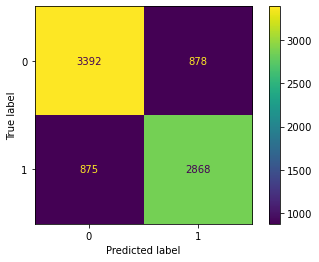

In [59]:
plot_confusion_matrix(final_model_se, X_test, y_test.seasonal_vaccine)  
plt.show();

### ROC Curve

In [60]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

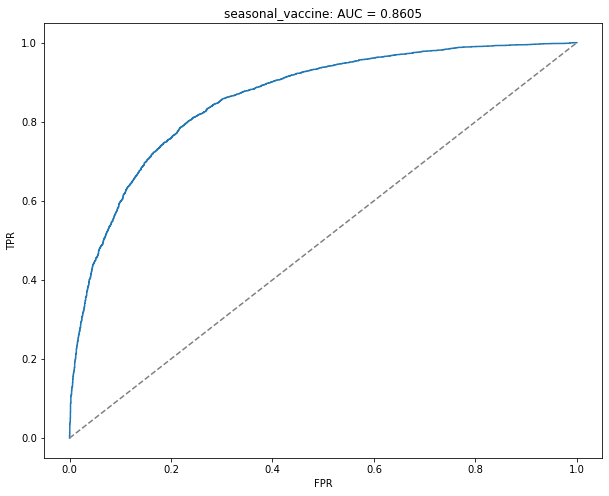

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

## Competition Purposes

### Combined ROC Score

In [65]:
roc_auc_score(y_test, np.hstack((pred_h1n1, predictions_se)))

0.8658663609585904

## Training on full dataset

In [69]:
le = LabelEncoder()
for col in ord_cols:
    test[col] = le.fit_transform(test[col])

In [70]:
for col in ord_cols:
    pd.to_numeric(test[col])

### H1N1 Vaccine

In [71]:
best_model_h1n1.fit(train, labels.h1n1_vaccine)

In [72]:
final_h1 = best_model_h1n1.predict_proba(test)

In [73]:
final_h1 = final_h1[:,1].reshape(-1,1)

### Seasonal Vaccine

In [74]:
final_model_se.fit(train, labels.seasonal_vaccine)

In [75]:
final_se = final_model_se.predict_proba(test)

In [76]:
final_se = final_se[:,1].reshape(-1,1)

### Submission 

In [78]:
submission_df = pd.read_csv('data/submission_format.csv', index_col='respondent_id')

In [79]:
np.testing.assert_array_equal(test.index.values, submission_df.index.values)

In [81]:
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.219851,0.261056
26708,0.057439,0.027234
26709,0.328656,0.723902
26710,0.714017,0.896597
26711,0.441187,0.429705


In [82]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'./{date}submssion_catboost_optuna.csv', index=True)